In [1]:
from pyspark.sql import SparkSession
allocated_memory = 18 * 0.75 

# create a SparkSession
spark = SparkSession.builder.appName("ReadJSON")\
.config("spark.executor.memory", "6g") \
.master("local[*]")  \
.config("spark.driver.memory", "4g") \
.config("spark.network.timeout", "800s")\
.config("spark.executor.heartbeatInterval", "200s")\
.config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.memory.fraction", "0.8") \
.config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.3.3")\
.getOrCreate()

:: loading settings :: url = jar:file:/opt/homebrew/Cellar/apache-spark/3.5.1/libexec/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/kravisankaran/.ivy2/cache
The jars for the packages stored in: /Users/kravisankaran/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7d34931d-53c6-42fd-8983-9a4c57ddde0b;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.3.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType, ArrayType
# targetUDF = F.udf(lambda x: 1 if x >= 4.0 else (0 if x == 3.0 else -1), IntegerType())
targetUDF = F.udf(lambda x: 1 if x >= 4.0 else 0, IntegerType())

In [3]:
json_objects = []
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType
#"reviewerID": "A8WEXFRWX1ZHH", 
# "asin": "0209688726", 
# "style": {"Color:": " AC"}, 
# "reviewerName": "Goldengate",
# Define the schema
schema = StructType([
    StructField("overall", FloatType(), True),
    StructField("verified", BooleanType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("style", StructType([StructField("Color:", StringType(), True)]), True),
    StructField("reviewerName", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("unixReviewTime", IntegerType(), True)
    
])
def pre_process(chunk):
    print("Processing chunk")
    df = spark.createDataFrame(json_objects, schema=schema)
    reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
    unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
    unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
    df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
    return df_sentiment

In [4]:
# import sys
# import json
# import os
# import shutil

# from pyspark.sql.functions import rand
# from pyspark.ml.pipeline import PipelineModel

# # Define the maximum file size in bytes (10MB)
# max_file_size = 10 * 1024 * 1024

# json_objects = []

# # Read the file line by line until the maximum file size is reached
# with open(json_training_file_path, 'r') as file:
#     total_size = 0
#     for line in file:
#         # Calculate the size of the current line
#         line_size = sys.getsizeof(line)

#         # If adding the current line exceeds the maximum file size, stop reading
#         if total_size + line_size > max_file_size:
#             print(line_size, total_size)
#             # Create a DataFrame from the list of JSON objects
#             df = spark.createDataFrame(json_objects)
#             reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
#             unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
#             df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
#             tokenizer = Tokenizer(inputCol  = "reviewText",
#                       outputCol = "token")
#             # Remove the rows with missing values and tokenize
#             df_train_tokenized = tokenizer.transform(df_sentiment.filter(unique_df.reviewText.isNotNull()))
#             # remove hashtags, call outs and web addresses
#             df4_train = df_train_tokenized.withColumn("tokens_re", removeWEBUDF(df_train_tokenized["token"]))
#             # remove non english characters
#             df4_train = df4_train.withColumn("tokens_clean", normalizeUDF(df4_train["tokens_re"]))
#             # rename columns
#             df5_train = df4_train.drop("token","tokens_re")
#             df5_train = df5_train.withColumnRenamed("tokens_clean", "tokens")
#             # remove reviews where the tokens array is empty, i.e. where it was just
#             # a hashtag, callout, numbers, web adress etc.
#             df6_train = df5_train.where(F.size(F.col("tokens")) > 0)
#             df_train_for_model = df6_train.select("reviewText","sentiment").withColumnRenamed("sentiment", "label")
#             shuffled_train_df = df_train_for_model.orderBy(rand())
#             if os.path.exists('bigram_pipeline_model'):
#                 loaded_model = PipelineModel.load('bigram_pipeline_model')
#                 stages_steps = loaded_model.stages
#                 updated_model = Pipeline(stages = stages_steps).fit(shuffled_train_df)
#                 shutil.rmtree('bigram_pipeline_model')
#             else:
#                 updated_model = bigram_pipeline.fit(shuffled_train_df)

#             PipelineModel.save(updated_model, 'bigram_pipeline_model')
#             print('Model saved')
#             json_objects = []
#             total_size = 0
#         # Otherwise, add the line to the list of JSON objects
#         json_objects.append(json.loads(line))
#         total_size += line_size



In [5]:
from nltk.stem.porter import PorterStemmer
from pyspark import keyword_only
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    PosterStemming class using the NLTK Porter Stemmer
    
    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """
    
    @keyword_only
    def __init__(self, 
                 inputCol  : str = None, 
                 outputCol : str = None, 
                 min_size  : int = None):
        """
        Constructor takes in the input column name, output column name,
        plus the minimum legnth of a token (min_size)
        """
        # call Transformer classes constructor since were extending it.
        super(Transformer, self).__init__()

        # set Parameter objects minimum token size
        self.min_size = Param(self, "min_size", "")
        self._setDefault(min_size=0)

        # set the input keywork arguments
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

        # initialize Stemmer object
        self.stemmer  = PorterStemmer()

        
    @keyword_only
    def setParams(self, 
                  inputCol  : str = None, 
                  outputCol : str = None, 
                  min_size  : int = None
      ) -> None:
        """
        Function to set the keyword arguemnts
        """
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    

    def _stem_func(self, words  : list) -> list:
        """
        Stemmer function call that performs stemming on a
        list of tokens in words and returns a list of tokens
        that have meet the minimum length requiremnt.
        """
        # We need a way to get min_size and cannot access it 
        # with self.min_size
        min_size       = self.getMinSize()

        # stem that actual tokens by applying 
        # self.stemmer.stem function to each token in 
        # the words list
        stemmed_words  = map(self.stemmer.stem, words)

        # now create the new list of tokens from
        # stemmed_words by filtering out those
        # that are not of legnth > min_size
        filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

        return list(filtered_words)
    
    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Transform function is the method that is called in the 
        MLPipleline.  We have to override this function for our own use
        and have it call the _stem_func.

        Notice how it takes in a type DataFrame and returns type Dataframe
        """
        # Get the names of the input and output columns to use
        out_col       = self.getOutputCol()
        in_col        = self.getInputCol()

        # create the stemming function UDF by wrapping the stemmer 
        # method function
        stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))
        
        # now apply that UDF to the column in the dataframe to return
        # a new column that has the same list of words after being stemmed
        df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))

        return df2
  
  
    def setMinSize(self,value):
        """
        This method sets the minimum size value
        for the _paramMap dictionary.
        """
        self._paramMap[self.min_size] = value
        return self

    def getMinSize(self) -> int:
        """
        This method uses the parent classes (Transformer)
        .getOrDefault method to get the minimum
        size of a token.
        """
        return self.getOrDefault(self.min_size)


In [6]:
import os

from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.pipeline import PipelineModel
def identify_model_type(model_path):
    # Check if metadata exists to identify the model type
    metadata_path = os.path.join(model_path, 'metadata')
    if os.path.exists(metadata_path):
        with open(os.path.join(metadata_path, 'part-00000'), 'r') as file:
            metadata = json.load(file)
            return metadata['class']
    else: 
        try:
            model = CrossValidatorModel.load(model_path)
            del model
            return "CrossValidatorModel"
        except Exception as e1:
            # Try loading the model as PipelineModel
            try:
                model = PipelineModel.load(model_path)
                del model
                return "PipelineModel"
            except Exception as e2:
                return "Unknown model type"

In [15]:
# Building the pipeline for nlp transformers
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer, Stemmer

from pyspark.ml.feature import HashingTF, IDF, NGram
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

paramGrid = ParamGridBuilder() 

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
 

    nlpPipeline = Pipeline(stages=[
        documentAssembler, 
        tokenizer,
        stopwords_cleaner
    ])
    
    return nlpPipeline

def get_cross_val_pipeline():
    bigram2 = NGram(inputCol="stemmed", outputCol="bigrams", n=2)

    tf6 = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

    idf = IDF(inputCol="rawFeatures", outputCol="features")

    lr = LogisticRegression(maxIter=20)

    paramGrid = ParamGridBuilder() \
        .addGrid(idf.minDocFreq, [2, 5]) \
        .addGrid(lr.regParam, [0.0, 0.1]) \
        .build()
    stemmer = PorterStemming(inputCol="token", outputCol="stemmed")
 
    stemmed_bigram_pipeline = Pipeline(stages=[bigram2, tf6, idf, lr])
    return (stemmed_bigram_pipeline, paramGrid, stemmer)

def get_crossval_evaluator():
    stemmed_bigram_pipeline, paramGrid, stemmer = get_cross_val_pipeline()
    crossval = CrossValidator(estimator= stemmed_bigram_pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3,
                              parallelism=2
                              )
    return (crossval, stemmer)


<>:31: SyntaxWarning: invalid escape sequence '\w'
<>:31: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1d/rj0w684n0z533z06yt6wyj2h0000gn/T/ipykernel_54958/41447811.py:31: SyntaxWarning: invalid escape sequence '\w'
  .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)


In [9]:
# Define the maximum file size in bytes (10MB)
max_file_size = 10 * 1024 * 1024
json_training_file_path = "combined_train_data_chunked_10mb_latest.json"
import sys
import json
import os
import shutil
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.pipeline import PipelineModel
 


def transform_chunk(df):
    nlpPipeline = get_nlp_pipeline()
    tokenized_df = nlpPipeline.fit(df).transform(df)
    tokenized_df.show(1)
    #tokenized_df.select("cleanTokens.result").show(1)
    df6_train = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
    df_train_for_model = df6_train.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
    return df_train_for_model

def run_cross_validation(df_train, pipeline, stem_pipeline, run):
    stages_steps = []
    train_stem = stem_pipeline.transform(df_train)\
                          .where(F.size(F.col("stemmed")) >= 1)
    print("Run %d" % run)
    if os.path.exists('crossval_pipeline_model'):
        model_type = identify_model_type('crossval_pipeline_model')
        print("Model type: %s" % model_type)
        if "CrossValidatorModel" in model_type:
            loaded_model = CrossValidatorModel.load('crossval_pipeline_model')
            stages_steps = loaded_model.bestModel.stages 
        elif "PipelineModel" in model_type:
            loaded_model = PipelineModel.load('crossval_pipeline_model')
            stages_steps = loaded_model.stages
        else:
            raise ValueError("Unsupported or unknown model type")
        updated_model = Pipeline(stages = stages_steps).fit(train_stem)
        updated_model.write().overwrite().save('crossval_pipeline_model')
    else:
        print("Printing data frame for training")
        train_stem.show(1)
        updated_model = pipeline.fit(train_stem)
        updated_model.write().overwrite().save('crossval_pipeline_model')
    run +=1
    print('Model saved for current chunk')
    return run

run = 0
with open(json_training_file_path, 'r') as file:
    total_size = 0
    for line in file:
        line_size = sys.getsizeof(line)
        # print("Current line size: %d, Total size: %d" % (line_size, total_size))
        if total_size + line_size >= max_file_size:
            print("Current line size: %d, Total size: %d" % (line_size, total_size))
            df  = pre_process(line)
            print("Show the first row of the preprocessed chunk:")
            df.show(1)
            df_train = transform_chunk(df)
            print("Show the first row of the transformed chunk:")
            df_train.show(1)
            crossval, stemmer = get_crossval_evaluator()
            run = run_cross_validation(df_train, crossval, stemmer, run)
            del df
            del df_train
            json_objects = []
            total_size = 0
        json_objects.append(json.loads(line))
        total_size += line_size


Current line size: 509, Total size: 10485463
Processing chunk
Show the first row of the preprocessed chunk:


24/04/25 15:11:55 WARN TaskSetManager: Stage 6 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B00MAN6K54|Karma is a bitch ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


24/04/25 15:11:58 WARN TaskSetManager: Stage 9 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Karma is a bitch ...|    1|[Karma, bitch, ch...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 0
Model type: org.apache.spark.ml.tuning.CrossValidatorModel


24/04/25 15:12:05 WARN TaskSetManager: Stage 44 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 489, Total size: 10485356
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0689240FYOX63XMAO3Y|B006YKFYVK|Got it for my 6 M...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Got it for my 6 M...|    1|[Got, 6, Month, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 1
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:11 WARN TaskSetManager: Stage 75 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 551, Total size: 10485755
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100297S0KWNIB|B00GGIN32C|Worked for our pu...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Worked for our pu...|    1|[Worked, purposes...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 2
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:16 WARN TaskSetManager: Stage 106 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 506, Total size: 10485311
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A020433331IIQAID3WSG|B005OH6IPA|Arrived and it is...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Arrived and it is...|    1|[Arrived, right, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 3
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:21 WARN TaskSetManager: Stage 137 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2327, Total size: 10485265
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980358L4HV4VLJI3QT|B001AQQ4Z8|Good for little kids|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good for little kids|    1|[Good, little, kids]|
+--------------------+-----+--------------------+
only showing top 1 row

Run 4
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:26 WARN TaskSetManager: Stage 168 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 325, Total size: 10485706
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B00KY8GAAM|I must say this w...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I must say this w...|    1|[must, say, great...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 5
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:30 WARN TaskSetManager: Stage 199 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1643, Total size: 10484347
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00VD1VV58|I love home ethic...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love home ethic...|    1|[love, home, ethi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 6
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:34 WARN TaskSetManager: Stage 230 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 795, Total size: 10485627
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10030KC6GYK89|B00028IXC2|I was surprised t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was surprised t...|    1|[surprised, find,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 7
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:39 WARN TaskSetManager: Stage 261 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 762, Total size: 10485053
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0403142PTCZBLIH0GEF|B006MCVAJA|Wonderful product...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wonderful product...|    1|[Wonderful, produ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 8
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:43 WARN TaskSetManager: Stage 292 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 995, Total size: 10485201
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508493HJ7B5SE6V7TN|B0000AT0WE|Great locking mou...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great locking mou...|    1|[Great, locking, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 9
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:46 WARN TaskSetManager: Stage 323 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 533, Total size: 10485561
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0415852RV6U7JD8OV9G|B006R9GI2C|I have not used t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have not used t...|    1|[used, items, yet...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 10
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:49 WARN TaskSetManager: Stage 354 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1825, Total size: 10484755
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0220159ZRNBTRKLG08H|B00OY5T3OQ|Garbage. Does not...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Garbage. Does not...|    0|[Garbage, ., fit,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 11
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:53 WARN TaskSetManager: Stage 385 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1477, Total size: 10484445
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1021HGM02HIKB|B0002EQTIQ|Perfect for snack...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Perfect for snack...|    1|[Perfect, snackin...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 12
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:56 WARN TaskSetManager: Stage 416 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 506, Total size: 10485558
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0730101XOT31OKVKHYK|B008YFT7BQ|not what i expect...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|not what i expect...|    0|[expected, ,, thi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 13
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:12:59 WARN TaskSetManager: Stage 447 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 643, Total size: 10485171
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00WPVFCHI|This is the begin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is the begin...|    1|[beginning, great...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 14
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:02 WARN TaskSetManager: Stage 478 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 433, Total size: 10485746
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196552RI15HI7JB9PW|B00LNSBID6|Good  product\nwo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good  product\nwo...|    1|[Good, product, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 15
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:06 WARN TaskSetManager: Stage 509 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 973, Total size: 10485493
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100BB737UMFHX|B0002AQ2LY|Bubble filters do...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bubble filters do...|    1|[Bubble, filters,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 16
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:09 WARN TaskSetManager: Stage 540 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 630, Total size: 10485632
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0102335OJZYGD6JG8YQ|B00FEA8S2I|Light, rugged. Pr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Light, rugged. Pr...|    1|[Light, ,, rugged...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 17
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:12 WARN TaskSetManager: Stage 571 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 278, Total size: 10485722
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101VZZNUTBN9O|B00U1F6TO0|My chihuahua bark...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My chihuahua bark...|    1|[chihuahua, barks...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 18
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:15 WARN TaskSetManager: Stage 602 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 488, Total size: 10485476
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0595675HTCA2LNAC33A|B00DNJORL8|Not a fan of the ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not a fan of the ...|    1|[fan, bulk, packa...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 19
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:18 WARN TaskSetManager: Stage 633 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1483, Total size: 10484354
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A06900664R2JKVGD4B5I|B00029WRMI|Awful!! Extremely...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awful!! Extremely...|    0|[Awful, !!, Extre...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 20
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:21 WARN TaskSetManager: Stage 664 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 677, Total size: 10485442
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0122375SQ8Z42DUL03J|B007IRMTXE|Works really well...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works really well...|    1|[Works, really, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 21
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:24 WARN TaskSetManager: Stage 695 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 315, Total size: 10485483
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1008A7IPWAN3M|B00S5E5G8Y|    GREAT!|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|    GREAT!|    1|[GREAT, !]|
+----------+-----+----------+
only showing top 1 row

Run 22
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:28 WARN TaskSetManager: Stage 726 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1032, Total size: 10485048
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B0002KKITG|I've been using s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've been using s...|    1|[using, stoner, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 23
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:31 WARN TaskSetManager: Stage 757 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 7944, Total size: 10478860
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A100WO06OQR8BQ|B00176T5I4|This is a totally...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a totally...|    0|[totally, useless...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 24
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:35 WARN TaskSetManager: Stage 788 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 271, Total size: 10485529
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B01HH7JSW4|This is a wonderf...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a wonderf...|    1|[wonderful, compi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 25
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:38 WARN TaskSetManager: Stage 819 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 578, Total size: 10485718
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0994261IXWIKPX087WZ|B00DMPQYHI|This pump has sat...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This pump has sat...|    1|[pump, satisfied,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 26
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:41 WARN TaskSetManager: Stage 850 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 493, Total size: 10485708
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0815414IQ081GR6BB0I|B00QR1U9X4|100% annoying. No...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|100% annoying. No...|    0|[100%, annoying, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 27
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:44 WARN TaskSetManager: Stage 881 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1319, Total size: 10484992
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1001UHWPK1BIB|B000FFIL60|Not bad. Jasmine ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not bad. Jasmine ...|    1|[bad, ., Jasmine,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 28
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:47 WARN TaskSetManager: Stage 912 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 331, Total size: 10485492
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A06900664R2JKVGD4B5I|B00T6IXPXG|It's awesome! Jus...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's awesome! Jus...|    1|[awesome, !, keep...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 29
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:50 WARN TaskSetManager: Stage 943 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1139, Total size: 10485650
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+---------------+---------+
|overall|          reviewerID|      asin|     reviewText|sentiment|
+-------+--------------------+----------+---------------+---------+
|    5.0|A0980358L4HV4VLJI3QT|B007F8XJMG|Good protection|        1|
+-------+--------------------+----------+---------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+---------------+-----+------------------+
|     reviewText|label|             token|
+---------------+-----+------------------+
|Good protection|    1|[Good, protection]|
+---------------+-----+------------------+
only showing top 1 row

Run 30
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:53 WARN TaskSetManager: Stage 974 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3841, Total size: 10484871
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UXMXYOQU1X|B000WWIPEE|Works great!  You...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works great!  You...|    1|[Works, great, !,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 31
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:13:56 WARN TaskSetManager: Stage 1005 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 498, Total size: 10485613
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A101GDRKHYM662|B0017JASSW|This product prec...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This product prec...|    0|[product, precipi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 32
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:00 WARN TaskSetManager: Stage 1036 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 650, Total size: 10485276
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1012PSARX3LDJ|B00PL54K7I|Great light, has ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great light, has ...|    1|[Great, light, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 33
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:02 WARN TaskSetManager: Stage 1067 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1080, Total size: 10485188
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103D6W7TXOLI2|B000NPPB1A|its a small flatb...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|its a small flatb...|    1|[small, flatbar, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 34
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:05 WARN TaskSetManager: Stage 1098 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1080, Total size: 10485339
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00BMTQNQ8|Being blind doesn...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Being blind doesn...|    1|[blind, mean, see...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 35
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:08 WARN TaskSetManager: Stage 1129 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 405, Total size: 10485656
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B001T9AFBK|Been using stoner...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Been using stoner...|    1|[using, stoner, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 36
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:11 WARN TaskSetManager: Stage 1160 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1160, Total size: 10485336
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A01910163UJ08PFOKPI6|B00FURVI6S|I ordered 2 of th...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I ordered 2 of th...|    0|[ordered, 2, time...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 37
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:14 WARN TaskSetManager: Stage 1191 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3470, Total size: 10483922
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1011UZJAELNPL|B0199RSZOC|The only problem ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The only problem ...|    0|[problem, story, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 38
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:17 WARN TaskSetManager: Stage 1222 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 597, Total size: 10485444
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A102MPY5LHR334|B01C47QGPE|Not comparable to...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not comparable to...|    0|[comparable, adva...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 39
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:20 WARN TaskSetManager: Stage 1253 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1637, Total size: 10484674
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B000E28MTA| Excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| Excellent|    1|[Excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 40
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:24 WARN TaskSetManager: Stage 1284 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 422, Total size: 10485671
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0579792GG3MNILZ71RV|B005C1Y9D6|Honda pilot led l...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Honda pilot led l...|    1|[Honda, pilot, le...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 41
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:27 WARN TaskSetManager: Stage 1315 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 438, Total size: 10485486
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00NCRUD0A|You never know wh...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|You never know wh...|    1|[never, know, rea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 42
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:30 WARN TaskSetManager: Stage 1346 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1247, Total size: 10485355
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0397816ZJHDVVI9IRM1|B000XOLKFW|fits good, missin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|fits good, missin...|    1|[fits, good, ,, m...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 43
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:32 WARN TaskSetManager: Stage 1377 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 757, Total size: 10485672
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0165490GQW9X6ELEQG8|B00CNIDH7K|Totally Surprised...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Totally Surprised...|    1|[Totally, Surpris...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 44
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:35 WARN TaskSetManager: Stage 1408 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2277, Total size: 10485380
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0122375SQ8Z42DUL03J|B00ZP6HS6S|She checked it ou...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She checked it ou...|    1|[checked, zipped,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 45
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:38 WARN TaskSetManager: Stage 1439 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1370, Total size: 10484915
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101C2665VHZ7E|B01AO0GF6I|My child loves th...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My child loves th...|    1|[child, loves, ki...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 46
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:40 WARN TaskSetManager: Stage 1470 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 722, Total size: 10485725
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0415852RV6U7JD8OV9G|B00E1OSCEM|Necessary for tho...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Necessary for tho...|    1|[Necessary, knit,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 47
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:43 WARN TaskSetManager: Stage 1501 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 475, Total size: 10485322
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0085845UER34CCMXCHL|B0002ARYWU|We've been buying...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We've been buying...|    1|[buying, jolly, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 48
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:46 WARN TaskSetManager: Stage 1532 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 413, Total size: 10485409
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00XJZ6LV0|There must be som...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|There must be som...|    1|[must, something,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 49
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:50 WARN TaskSetManager: Stage 1563 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3737, Total size: 10484875
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0289048PRWFY7ZXQKCD|B00WEV4NPG|I've never found ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've never found ...|    0|[never, found, re...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 50
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:52 WARN TaskSetManager: Stage 1594 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 395, Total size: 10485491
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A101EVFXW8G49L|B00B0FT2T4|I somehow purchas...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I somehow purchas...|    0|[somehow, purchas...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 51
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:55 WARN TaskSetManager: Stage 1625 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4803, Total size: 10482742
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0862583SGINX9LS6XJ1|B000C32J5O|The only real way...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The only real way...|    1|[real, way, stop,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 52
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:14:58 WARN TaskSetManager: Stage 1656 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3022, Total size: 10484632
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0178408Z1TQAM7D75FY|B00TVG0LDK|I liked this book...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I liked this book...|    1|[liked, book, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 53
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:01 WARN TaskSetManager: Stage 1687 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 308, Total size: 10485541
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0436342QLT4257JODYJ|B002WYM6NQ|I needed somewher...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I needed somewher...|    1|[needed, somewher...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 54
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:03 WARN TaskSetManager: Stage 1718 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 569, Total size: 10485282
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100MPP98YN1U6|B000GLOFTU|Man, but this sur...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Man, but this sur...|    1|[Man, ,, sure, ki...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 55
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:06 WARN TaskSetManager: Stage 1749 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3670, Total size: 10482104
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A07461691T3ZPYIJW2MO|B00BW0RGBI|       5/5|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----+
|reviewText|label|token|
+----------+-----+-----+
|       5/5|    1|[5/5]|
+----------+-----+-----+
only showing top 1 row

Run 56
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:11 WARN TaskSetManager: Stage 1780 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1255, Total size: 10484650
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0731751WJ9S3CJ2X7R3|B019TEM00K| Good book|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
| Good book|    1|[Good, book]|
+----------+-----+------------+
only showing top 1 row

Run 57
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:14 WARN TaskSetManager: Stage 1811 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 7947, Total size: 10478617
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00N992IFY|Rick has everythi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Rick has everythi...|    1|[Rick, everything...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 58
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:16 WARN TaskSetManager: Stage 1842 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1095, Total size: 10485377
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00GG1C83Y|This is a very fu...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a very fu...|    1|[fun, read, ,, pa...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 59
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:21 WARN TaskSetManager: Stage 1873 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1175, Total size: 10484997
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0954586PW98I9TNZXJP|B00OUAQAOQ|While this scratc...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|While this scratc...|    0|[scratcher, sturd...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 60
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:25 WARN TaskSetManager: Stage 1904 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 950, Total size: 10485233
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A07461691T3ZPYIJW2MO|B00BW0RF3W|       5/5|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----+
|reviewText|label|token|
+----------+-----+-----+
|       5/5|    1|[5/5]|
+----------+-----+-----+
only showing top 1 row

Run 61
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:28 WARN TaskSetManager: Stage 1935 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 441, Total size: 10485430
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A02635363YZWI9MI13CD|B005GLNAFK|to dim and does n...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|to dim and does n...|    0|[dim, fit, need, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 62
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:32 WARN TaskSetManager: Stage 1966 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1189, Total size: 10484928
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0108361NUAPHEN2W129|B006UJGFZY|I have a 10 lb ch...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have a 10 lb ch...|    0|[10, lb, chi, kno...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 63
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:36 WARN TaskSetManager: Stage 1997 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 446, Total size: 10485704
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A100DE0GESG8HY|B004JBB22G|1 out of the 3 pa...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|1 out of the 3 pa...|    0|[1, 3, packs, see...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 64
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:40 WARN TaskSetManager: Stage 2028 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1162, Total size: 10484946
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01888QTL4|You can not trust...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|You can not trust...|    1|[trust, anybody, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 65
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:43 WARN TaskSetManager: Stage 2059 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 927, Total size: 10485107
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B016U3FA8M|Thanksgiving is c...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Thanksgiving is c...|    1|[Thanksgiving, co...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 66
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:47 WARN TaskSetManager: Stage 2090 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 320, Total size: 10485462
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B016DX8ZHC|This is my first ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is my first ...|    1|[first, Black, Hi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 67
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:50 WARN TaskSetManager: Stage 2121 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 407, Total size: 10485404
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B00JFT6JE8|My Dobie is getti...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My Dobie is getti...|    1|[Dobie, getting, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 68
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:53 WARN TaskSetManager: Stage 2152 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3775, Total size: 10484009
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0743345UFTOA4V1Z7W|B000IAIP72|Haven't used it y...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Haven't used it y...|    1|[used, yet, ., Go...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 69
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:56 WARN TaskSetManager: Stage 2183 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 422, Total size: 10485489
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A100DO844MBA4W|B005GSYIV8|I WISH my cat lik...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I WISH my cat lik...|    0|[WISH, cat, liked...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 70
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:15:59 WARN TaskSetManager: Stage 2214 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 955, Total size: 10485471
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0328927TA7ECTIKNP3G|B00BJNDITW|My hero, he can s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My hero, he can s...|    1|[hero, ,, seduce,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 71
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:03 WARN TaskSetManager: Stage 2245 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 695, Total size: 10485521
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1031T963BGNRU|B019Y3NCAI|Really incredibly...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Really incredibly...|    1|[Really, incredib...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 72
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:07 WARN TaskSetManager: Stage 2276 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 600, Total size: 10485248
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0527988KUR7884GZD9A|B006CQ1ZHI|The taste is grea...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The taste is grea...|    1|[taste, great, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 73
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:10 WARN TaskSetManager: Stage 2307 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1434, Total size: 10484390
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A102LBNR54QVHM|B001VP565M|My dog really lik...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My dog really lik...|    0|[dog, really, lik...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 74
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:14 WARN TaskSetManager: Stage 2338 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 411, Total size: 10485618
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0787942UFOPVFL0MFMB|B00DSD58DA|Good quality stic...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good quality stic...|    1|[Good, quality, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 75
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:17 WARN TaskSetManager: Stage 2369 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 685, Total size: 10485111
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0769183K7L2H54MJRG4|B0079XPUOW|Clever.  Fun.  Un...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Clever.  Fun.  Un...|    1|[Clever, ., Fun, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 76
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:21 WARN TaskSetManager: Stage 2400 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3514, Total size: 10485581
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101RGQP89LYZI|B00PBUEQJK|Great book. I rea...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great book. I rea...|    1|[Great, book, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 77
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:24 WARN TaskSetManager: Stage 2431 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 840, Total size: 10485475
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B017JAJ5G8|Jason is beset up...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Jason is beset up...|    1|[Jason, beset, up...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 78
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:28 WARN TaskSetManager: Stage 2462 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2509, Total size: 10483618
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100E61UIJH3B5|B001E3RPKK|Very easy to keep...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very easy to keep...|    1|[easy, keep, clea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 79
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:31 WARN TaskSetManager: Stage 2493 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2806, Total size: 10483307
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101U7FNC994O3|B00NNDXT68|The way the book ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The way the book ...|    1|[way, book, start...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 80
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:34 WARN TaskSetManager: Stage 2524 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1696, Total size: 10484679
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00L5AYW3A|Is Javier really ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Is Javier really ...|    1|[Javier, really, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 81
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:37 WARN TaskSetManager: Stage 2555 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 346, Total size: 10485565
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A07716593573L93RJQ1E|B00FRI5TMY|Nice, if it worke...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Nice, if it worke...|    0|[Nice, ,, worked,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 82
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:40 WARN TaskSetManager: Stage 2586 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 408, Total size: 10485538
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1017UZIPW58F4|B00F6PAPUO|Shipping took for...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Shipping took for...|    1|[Shipping, took, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 83
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:44 WARN TaskSetManager: Stage 2617 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5376, Total size: 10485415
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0620511OK30N45S3WVF|B0002YX7MM|This was the best...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was the best...|    1|[best, price, far...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 84
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:50 WARN TaskSetManager: Stage 2648 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 660, Total size: 10485404
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B016B636SO|5+++++ Stars this...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|5+++++ Stars this...|    1|[5+++++, Stars, o...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 85
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:53 WARN TaskSetManager: Stage 2679 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1826, Total size: 10484798
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DFH9N1KS7T|B00NFSM49Y|This music lifts ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+-----------------+
|          reviewText|label|            token|
+--------------------+-----+-----------------+
|This music lifts ...|    1|[music, lifts, .]|
+--------------------+-----+-----------------+
only showing top 1 row

Run 86
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:16:56 WARN TaskSetManager: Stage 2710 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 341, Total size: 10485563
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B00FFC9QSK|What can I say I ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What can I say I ...|    1|[say, Love, Kinnc...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 87
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:00 WARN TaskSetManager: Stage 2741 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 446, Total size: 10485677
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B00OQI625O|This was so good....|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was so good....|    1|[good, ., Every, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 88
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:03 WARN TaskSetManager: Stage 2772 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 303, Total size: 10485493
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1017T4YMQMZ1X|B000E8UR24|I was not able to...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was not able to...|    0|[able, try, fauce...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 89
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:06 WARN TaskSetManager: Stage 2803 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 361, Total size: 10485571
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    4.0|A0096681Y127OL1H8W3U|B000HHNYHW|good product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 90
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:09 WARN TaskSetManager: Stage 2834 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1401, Total size: 10484958
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0024936S1WI02OHH9DP|B016AG5DR2|Looks great fits ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great fits ...|    1|[Looks, great, fi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 91
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:12 WARN TaskSetManager: Stage 2865 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1638, Total size: 10485270
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A047816347FS2EFQ6VEY|B007X93M4C|Book has simple r...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Book has simple r...|    1|[Book, simple, re...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 92
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:16 WARN TaskSetManager: Stage 2896 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 315, Total size: 10485719
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0944456Z3LN62I2DT3O|B01C7QAK7C|Works perfect and...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works perfect and...|    1|[Works, perfect, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 93
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:19 WARN TaskSetManager: Stage 2927 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 554, Total size: 10485297
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B000C9NA8S|Bought this canis...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought this canis...|    1|[Bought, canister...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 94
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:23 WARN TaskSetManager: Stage 2958 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 793, Total size: 10485270
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100I8XXUFVRCM|B00WZ8WDTG|Top quality but m...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Top quality but m...|    1|[Top, quality, do...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 95
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:26 WARN TaskSetManager: Stage 2989 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 814, Total size: 10485665
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------------+---------+
|overall|          reviewerID|      asin|        reviewText|sentiment|
+-------+--------------------+----------+------------------+---------+
|    5.0|A0629255VPARUWJZM5XI|B009IISLLU|Good solid product|        1|
+-------+--------------------+----------+------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------------+-----+--------------------+
|        reviewText|label|               token|
+------------------+-----+--------------------+
|Good solid product|    1|[Good, solid, pro...|
+------------------+-----+--------------------+
only showing top 1 row

Run 96
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:30 WARN TaskSetManager: Stage 3020 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4444, Total size: 10482151
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0926538LGZ1P4CJAQO2|B00WSJXJE0|This got 5 stars ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This got 5 stars ...|    1|[got, 5, stars, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 97
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:33 WARN TaskSetManager: Stage 3051 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 6299, Total size: 10480938
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0968684PHO6YBBM3WA6|B00H1NNFTW|Looks good on my ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks good on my ...|    1|[Looks, good, 22r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 98
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:36 WARN TaskSetManager: Stage 3082 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1246, Total size: 10485639
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A108B8OUQ0GHNF|B001T4FGS2|Great file handle...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great file handle...|    1|[Great, file, han...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 99
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:38 WARN TaskSetManager: Stage 3113 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 298, Total size: 10485622
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0807760H1KAYIBFPIS|B00FA61KNU|Well I enjoyed th...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Well I enjoyed th...|    1|[Well, enjoyed, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 100
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:41 WARN TaskSetManager: Stage 3144 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5859, Total size: 10485529
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0705654XT5UCAYOY7TH|B00F94YP8A|Delicious! So but...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Delicious! So but...|    1|[Delicious, !, bu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 101
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:44 WARN TaskSetManager: Stage 3175 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2902, Total size: 10485122
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1019XHLIPLYCD|B001Q3KUAK|My daughter got t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My daughter got t...|    1|[daughter, got, j...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 102
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:46 WARN TaskSetManager: Stage 3206 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 735, Total size: 10485664
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A100GL2NQS0533|B00DTEZZ9A|Only 3 stars caus...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Only 3 stars caus...|    0|[3, stars, cause,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 103
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:49 WARN TaskSetManager: Stage 3237 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 316, Total size: 10485491
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B0093J41PE|Walnuts are one o...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Walnuts are one o...|    1|[Walnuts, one, fa...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 104
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:51 WARN TaskSetManager: Stage 3268 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 349, Total size: 10485583
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101DH2EE0D7P4|B00BGS31MO|Works well I gues...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works well I gues...|    1|[Works, well, gue...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 105
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:54 WARN TaskSetManager: Stage 3299 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 629, Total size: 10485712
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0262876TDA2EYEV3LVJ|B00IPCOVTG|My bunny loves th...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My bunny loves th...|    0|[bunny, loves, fi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 106
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:57 WARN TaskSetManager: Stage 3330 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 581, Total size: 10485232
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00GJCNLWC|This was a very e...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a very e...|    1|[exciting, book, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 107
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:17:59 WARN TaskSetManager: Stage 3361 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 528, Total size: 10485565
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102NKLXRT5KEM|B0044UZSPY|My Vet recommende...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My Vet recommende...|    1|[Vet, recommended...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 108
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:02 WARN TaskSetManager: Stage 3392 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 354, Total size: 10485725
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    2.0|A0225879AOG5GLHAB7EH|B000MCICC4|       ok.|        0|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|       ok.|    0|[ok, .]|
+----------+-----+-------+
only showing top 1 row

Run 109
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:05 WARN TaskSetManager: Stage 3423 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 290, Total size: 10485612
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0102335OJZYGD6JG8YQ|B01BLEWFGK|Even not covering...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Even not covering...|    1|[Even, covering, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 110
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:09 WARN TaskSetManager: Stage 3454 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 274, Total size: 10485729
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100ELBI8BSXR1|B00006IX59|WATCH THOSE TENNI...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WATCH THOSE TENNI...|    1|[WATCH, TENNIS, B...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 111
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:13 WARN TaskSetManager: Stage 3485 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1346, Total size: 10485680
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0486341RMMNBBGS1G4X|B01489LL4M|Perfect for our b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Perfect for our b...|    1|[Perfect, barnyar...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 112
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:16 WARN TaskSetManager: Stage 3516 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2275, Total size: 10485576
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0362231G0D49Y5H52ES|B0000302V3|works as advertis...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|works as advertis...|    1|[works, advertise...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 113
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:19 WARN TaskSetManager: Stage 3547 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1163, Total size: 10484813
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0323662LGDA74F87HNI|B00SQK9GZQ|Yes, double faced...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Yes, double faced...|    1|[Yes, ,, double, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 114
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:22 WARN TaskSetManager: Stage 3578 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 492, Total size: 10485539
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10030KC6GYK89|B00D63QTAI|Good story, a lit...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good story, a lit...|    1|[Good, story, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 115
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:25 WARN TaskSetManager: Stage 3609 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 461, Total size: 10485484
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0191512Q2Z9IPUAE2RZ|B00A97FIG0|Used a Trane Weat...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Used a Trane Weat...|    1|[Used, Trane, Wea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 116
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:28 WARN TaskSetManager: Stage 3640 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 596, Total size: 10485517
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10002EO9ZUY0B|B0017R5UIW|a step forward fo...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|a step forward fo...|    1|[step, forward, m...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 117
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:34 WARN TaskSetManager: Stage 3671 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1630, Total size: 10485421
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0539606PFOMM461E03I|B00MN9DNNW|Lights aren't the...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Lights aren't the...|    1|[Lights, best, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 118
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:37 WARN TaskSetManager: Stage 3702 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 432, Total size: 10485543
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B006ZRUKHK|use it to rust pr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|use it to rust pr...|    1|[use, rust, proof...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 119
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:40 WARN TaskSetManager: Stage 3733 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3331, Total size: 10482491
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B01DH1XXG6|Just as the lates...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Just as the lates...|    1|[latest, presiden...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 120
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:46 WARN TaskSetManager: Stage 3764 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2550, Total size: 10485637
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0671524HJIZUG70O7CE|B01EJL2S2S|Worked ok in fron...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Worked ok in fron...|    0|[Worked, ok, fron...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 121
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:49 WARN TaskSetManager: Stage 3795 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 878, Total size: 10485133
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0232309XTWAG6FEGW93|B00CCC281S|A beautiful littl...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A beautiful littl...|    1|[beautiful, littl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 122
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:52 WARN TaskSetManager: Stage 3826 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 418, Total size: 10485402
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00201164H8T5GSBKYFP|B0000025HU|What I like, is v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What I like, is v...|    1|[like, ,, good, f...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 123
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:18:56 WARN TaskSetManager: Stage 3857 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2352, Total size: 10484457
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B0062ADT6E|I had installed o...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I had installed o...|    1|[installed, one, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 124
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:00 WARN TaskSetManager: Stage 3888 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 441, Total size: 10485458
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07936821FOVJO6NP4Q8|B0037UUO60|Had one of these ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Had one of these ...|    1|[one, aircraft, m...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 125
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:02 WARN TaskSetManager: Stage 3919 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 553, Total size: 10485427
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+-----------+---------+
|overall|    reviewerID|      asin| reviewText|sentiment|
+-------+--------------+----------+-----------+---------+
|    5.0|A100JY2S79BBM6|B00K9BFKNM|Great value|        1|
+-------+--------------+----------+-----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-----------+-----+--------------+
| reviewText|label|         token|
+-----------+-----+--------------+
|Great value|    1|[Great, value]|
+-----------+-----+--------------+
only showing top 1 row

Run 126
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:07 WARN TaskSetManager: Stage 3950 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 606, Total size: 10485407
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103KNDW8GN92L|B000002PCT|"Pretzel Logic", ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|"Pretzel Logic", ...|    1|[", Pretzel, Logi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 127
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:12 WARN TaskSetManager: Stage 3981 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 928, Total size: 10485063
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0886097YX1F6V4PD6J7|B00PHAEFVS|it can not end th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|it can not end th...|    1|[end, book, 4, Za...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 128
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:15 WARN TaskSetManager: Stage 4012 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 261, Total size: 10485700
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B00FWUTRBQ|I tried to find t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I tried to find t...|    1|[tried, find, fro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 129
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:18 WARN TaskSetManager: Stage 4043 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 344, Total size: 10485736
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0526222H977CBZM4DK7|B0039QXWPM| EXCELLENT|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| EXCELLENT|    1|[EXCELLENT]|
+----------+-----+-----------+
only showing top 1 row

Run 130
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:22 WARN TaskSetManager: Stage 4074 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 595, Total size: 10485647
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0807760H1KAYIBFPIS|B00PB64194|I am in love with...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I am in love with...|    1|[love, characters...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 131
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:25 WARN TaskSetManager: Stage 4105 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2669, Total size: 10484383
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-----------+---------+
|overall|          reviewerID|      asin| reviewText|sentiment|
+-------+--------------------+----------+-----------+---------+
|    4.0|A0441818S7W7N4A7QL55|B018VLH7D2|As expected|        1|
+-------+--------------------+----------+-----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-----------+-----+----------+
| reviewText|label|     token|
+-----------+-----+----------+
|As expected|    1|[expected]|
+-----------+-----+----------+
only showing top 1 row

Run 132
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:28 WARN TaskSetManager: Stage 4136 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1284, Total size: 10485612
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A01631062UX24GI4LJKF|B00HI4V5FU|I have to admit I...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have to admit I...|    1|[admit, gonna, bu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 133
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:31 WARN TaskSetManager: Stage 4167 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 704, Total size: 10485171
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B017KQTTIK|PTSD is a horribl...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|PTSD is a horribl...|    1|[PTSD, horrible, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 134
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:34 WARN TaskSetManager: Stage 4198 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 693, Total size: 10485314
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0610173AX4RY4WQ9LR7|B000YFUQ7I|Got it for the gr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Got it for the gr...|    1|[Got, grandson, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 135
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:37 WARN TaskSetManager: Stage 4229 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 395, Total size: 10485365
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1007QP6OB28XH|B005WZQJV2|Ok bulbs but not ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Ok bulbs but not ...|    0|[Ok, bulbs, blue,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 136
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:40 WARN TaskSetManager: Stage 4260 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 541, Total size: 10485316
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00408825PVJW7GFLEGU|B005DL8NJG|good shampoo, cat...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|good shampoo, cat...|    1|[good, shampoo, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 137
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:44 WARN TaskSetManager: Stage 4291 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3467, Total size: 10482614
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    1.0|A0988845PBOUFQEW351Q|B005CHHZH2|Bubbles easy|        0|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|Bubbles easy|    0|[Bubbles, easy]|
+------------+-----+---------------+
only showing top 1 row

Run 138
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:48 WARN TaskSetManager: Stage 4322 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 341, Total size: 10485568
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10284FAGR5CGT|B000C5GAQQ|Perfect fit. Thes...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Perfect fit. Thes...|    1|[Perfect, fit, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 139
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:51 WARN TaskSetManager: Stage 4353 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1350, Total size: 10484689
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A10063PJ5C9WQQ|B000GAS2WW|wanted this to co...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|wanted this to co...|    0|[wanted, control,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 140
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:54 WARN TaskSetManager: Stage 4384 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 383, Total size: 10485628
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0980592Q6W60Q720SET|B00K43543Q|For some reason I...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|For some reason I...|    0|[reason, hard, ha...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 141
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:19:59 WARN TaskSetManager: Stage 4415 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1871, Total size: 10485622
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0598317G3T7URZAR3W3|B0024E6QX0|I bought these to...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought these to...|    1|[bought, save, ru...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 142
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:02 WARN TaskSetManager: Stage 4446 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 310, Total size: 10485531
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0205727NVAUDXS07YYO|B00OEXP0UE|Just love these. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Just love these. ...|    1|[love, ., Excelle...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 143
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:04 WARN TaskSetManager: Stage 4477 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 626, Total size: 10485499
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A03056324Y8DG2MLJQJU|B00P0D4V8Y|4.5 stars <3\n\nT...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|4.5 stars <3\n\nT...|    1|[4.5, stars, <3, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 144
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:07 WARN TaskSetManager: Stage 4508 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 832, Total size: 10485028
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0015332H21AK8WZ0ZCS|B005FTN30U|My 2 have not sho...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My 2 have not sho...|    0|[2, shown, intere...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 145
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:10 WARN TaskSetManager: Stage 4539 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1367, Total size: 10485218
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0024836TBQJ1WBE4VDY|B00BZ3DDYG|      nice|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 146
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:16 WARN TaskSetManager: Stage 4570 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1150, Total size: 10485162
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0856409EA8IMJ9T1VUW|B01AR61DLG|Case is solid blu...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Case is solid blu...|    0|[Case, solid, blu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 147
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:18 WARN TaskSetManager: Stage 4601 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1446, Total size: 10485638
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B01DV4HTFK|I love this serie...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love this serie...|    1|[love, series, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 148
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:21 WARN TaskSetManager: Stage 4632 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 8242, Total size: 10480280
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0667922P09C0VQOKCB|B00AR9F5HC|Great cut out Cam...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great cut out Cam...|    1|[Great, cut, Came...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 149
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:26 WARN TaskSetManager: Stage 4663 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1253, Total size: 10484706
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0015332H21AK8WZ0ZCS|B005G030TC|These collars are...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These collars are...|    1|[collars, actuall...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 150
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:29 WARN TaskSetManager: Stage 4694 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 706, Total size: 10485594
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00O27QJIE|The Timber Valley...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The Timber Valley...|    1|[Timber, Valley, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 151
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:33 WARN TaskSetManager: Stage 4725 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 583, Total size: 10485742
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101P2KHWCU0G6|B000VK4K3W|Unfortunately, I ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Unfortunately, I ...|    1|[Unfortunately, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 152
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:37 WARN TaskSetManager: Stage 4756 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1351, Total size: 10484887
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0178408Z1TQAM7D75FY|B01BLX4CN0|I received this b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I received this b...|    1|[received, book, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 153
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:41 WARN TaskSetManager: Stage 4787 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2369, Total size: 10485102
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0002APLYI|super nice...|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|super nice...|    1|[super, nice, ...]|
+-------------+-----+------------------+
only showing top 1 row

Run 154
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:44 WARN TaskSetManager: Stage 4818 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1011, Total size: 10484892
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0008898NGEXICE0F146|B00FXIFBLC|  Like!!!!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
|  Like!!!!|    1|[Like, !!!!]|
+----------+-----+------------+
only showing top 1 row

Run 155
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:47 WARN TaskSetManager: Stage 4849 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 414, Total size: 10485480
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WHZANWTAV4|B00F2MQ410|My son absolutely...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My son absolutely...|    1|[son, absolutely,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 156
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:50 WARN TaskSetManager: Stage 4880 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 284, Total size: 10485542
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A102D7NPKXXS5F|B00473PVVO|Best I ever taste...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Best I ever taste...|    1|[Best, ever, tast...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 157
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:55 WARN TaskSetManager: Stage 4911 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 558, Total size: 10485456
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00LU32E1Y|This chick has me...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This chick has me...|    1|[chick, mental, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 158
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:20:58 WARN TaskSetManager: Stage 4942 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2954, Total size: 10484054
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01189826IYDD95102EY|B0009IBJAS|They work great ....|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They work great ....|    1|[work, great, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 159
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:01 WARN TaskSetManager: Stage 4973 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5112, Total size: 10483174
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00WJ2OJMM|This was a beauti...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a beauti...|    1|[beautiful, story...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 160
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:05 WARN TaskSetManager: Stage 5004 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3137, Total size: 10485507
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+------------+---------+
|overall|    reviewerID|      asin|  reviewText|sentiment|
+-------+--------------+----------+------------+---------+
|    5.0|A102FEF1WMFWW4|B000LNVWAI|Works great.|        1|
+-------+--------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+-----------------+
|  reviewText|label|            token|
+------------+-----+-----------------+
|Works great.|    1|[Works, great, .]|
+------------+-----+-----------------+
only showing top 1 row

Run 161
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:08 WARN TaskSetManager: Stage 5035 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1790, Total size: 10485553
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A00222906VX8GH7X6J6B|B001US4DOK|good quality|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good quality|    1|[good, quality]|
+------------+-----+---------------+
only showing top 1 row

Run 162
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:12 WARN TaskSetManager: Stage 5066 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 999, Total size: 10485230
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00RCIBC8C|This was a great ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a great ...|    1|[great, book,I, e...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 163
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:15 WARN TaskSetManager: Stage 5097 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 918, Total size: 10485002
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A007125785FZVNMYL9Q1|B000CIGE96|Easy install on m...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Easy install on m...|    1|[Easy, install, 8...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 164
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:18 WARN TaskSetManager: Stage 5128 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1781, Total size: 10485618
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0001528BGUBOEVR6T5U|B00EOEDJ9W|Not stable. Had t...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not stable. Had t...|    0|[stable, ., retur...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 165
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:23 WARN TaskSetManager: Stage 5159 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 448, Total size: 10485368
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0441396WX3GNL93BT38|B00S9Y0CDY|It's not big like...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's not big like...|    0|[big, like, thoug...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 166
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:26 WARN TaskSetManager: Stage 5190 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1488, Total size: 10484779
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B01FL4AYUK|Easy to put on an...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Easy to put on an...|    1|[Easy, put, take,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 167
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:29 WARN TaskSetManager: Stage 5221 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1215, Total size: 10485743
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1000CJRHLJGY3|B0002F66HY|Spare tire cover ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Spare tire cover ...|    1|[Spare, tire, cov...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 168
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:32 WARN TaskSetManager: Stage 5252 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 818, Total size: 10485422
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0241327M3OM2YQZ0Z8B|B007PV1Z42|Looks great but h...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great but h...|    0|[Looks, great, ab...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 169
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:35 WARN TaskSetManager: Stage 5283 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 346, Total size: 10485647
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A0242421UVUJ5VDYGSLB|B01H2E82MO|Nice product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|Nice product|    1|[Nice, product]|
+------------+-----+---------------+
only showing top 1 row

Run 170
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:40 WARN TaskSetManager: Stage 5314 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 538, Total size: 10485665
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B000084F45|dogs said ummmmmm...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|dogs said ummmmmm...|    1|[dogs, said, ummm...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 171
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:43 WARN TaskSetManager: Stage 5345 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1595, Total size: 10485028
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0579792GG3MNILZ71RV|B0069TND14|I purchased based...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased based...|    1|[purchased, based...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 172
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:46 WARN TaskSetManager: Stage 5376 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2760, Total size: 10483439
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0539606PFOMM461E03I|B007FSN2UK|Awesome product. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome product. ...|    1|[Awesome, product...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 173
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:49 WARN TaskSetManager: Stage 5407 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 479, Total size: 10485665
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0163982I33BFLFLDW0T|B001DKRGLM|using it like I s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|using it like I s...|    1|[using, like, wor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 174
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:51 WARN TaskSetManager: Stage 5438 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 292, Total size: 10485689
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0710029OTHLNPXF58B3|B0140KUUUK|Broke the first t...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Broke the first t...|    0|[Broke, first, ti...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 175
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:55 WARN TaskSetManager: Stage 5469 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2331, Total size: 10484618
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100E61UIJH3B5|B001E3RPKK|I had a very larg...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I had a very larg...|    1|[large, dog, grea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 176
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:21:57 WARN TaskSetManager: Stage 5500 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 326, Total size: 10485587
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0595675HTCA2LNAC33A|B00P6P4C30|Bought this for m...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought this for m...|    1|[Bought, daughter...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 177
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:02 WARN TaskSetManager: Stage 5531 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2407, Total size: 10484259
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A007125785FZVNMYL9Q1|B004K23IP8|Has worked as des...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Has worked as des...|    1|[worked, designed...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 178
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:05 WARN TaskSetManager: Stage 5562 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1204, Total size: 10485549
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1031HVG5I7I7F|B01C83KB1E|This is a quality...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a quality...|    1|[quality, product...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 179
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:08 WARN TaskSetManager: Stage 5593 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2543, Total size: 10484653
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1002UBC6V258U|B00JOVJCI2|It is much larger...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It is much larger...|    0|[much, larger, ex...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 180
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:13 WARN TaskSetManager: Stage 5624 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1560, Total size: 10484605
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100IC7JRCQDUD|B000X9EDD8|This light works ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This light works ...|    1|[light, works, we...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 181
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:16 WARN TaskSetManager: Stage 5655 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 651, Total size: 10485600
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0441818S7W7N4A7QL55|B006O6EH4Y|Granddaughter lov...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Granddaughter lov...|    1|[Granddaughter, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 182
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:19 WARN TaskSetManager: Stage 5686 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 747, Total size: 10485674
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0240447UBWOLI8KGOGT|B008CTBK7S|I bought this pro...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought this pro...|    1|[bought, product,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 183
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:22 WARN TaskSetManager: Stage 5717 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 678, Total size: 10485683
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101XQIAMYU3X1|B005VEWAN0|I agree with a re...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I agree with a re...|    1|[agree, review, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 184
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:25 WARN TaskSetManager: Stage 5748 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 609, Total size: 10485226
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B01EKOGPIM|This book was giv...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book was giv...|    1|[book, given, aut...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 185
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:27 WARN TaskSetManager: Stage 5779 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 977, Total size: 10485750
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100T19LDH0GGN|B000002P7Z|A fantastically t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A fantastically t...|    1|[fantastically, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 186
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:30 WARN TaskSetManager: Stage 5810 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 346, Total size: 10485417
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A00201164H8T5GSBKYFP|B00914JWSW|I do not like is ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I do not like is ...|    0|[like, thing, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 187
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:34 WARN TaskSetManager: Stage 5841 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2948, Total size: 10483536
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B0058PBVQY|This is my first ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is my first ...|    1|[first, experienc...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 188
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:37 WARN TaskSetManager: Stage 5872 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2288, Total size: 10484005
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0281074R0QWE993EX2F|B00H3QRW6E|I absolutely LOVE...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I absolutely LOVE...|    1|[absolutely, LOVE...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 189
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:40 WARN TaskSetManager: Stage 5903 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1428, Total size: 10484446
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0352185LEEL6G01JJXG|B007Y2PMJQ|This was so hard ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was so hard ...|    0|[hard, get, found...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 190
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:45 WARN TaskSetManager: Stage 5934 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 911, Total size: 10485173
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00O9418Q8|A relationship wh...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A relationship wh...|    1|[relationship, be...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 191
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:50 WARN TaskSetManager: Stage 5965 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1032, Total size: 10485404
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B01CKCF4QU|I have been satis...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have been satis...|    1|[satisfied, Promi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 192
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:53 WARN TaskSetManager: Stage 5996 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2023, Total size: 10484025
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A035230154WEA8JCP8HS|B00SC0CPUS|Well she has done...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Well she has done...|    1|[Well, done, ., A...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 193
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:56 WARN TaskSetManager: Stage 6027 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 598, Total size: 10485601
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B00NNEIL0Q|One of my favorit...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|One of my favorit...|    1|[One, favorite, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 194
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:22:59 WARN TaskSetManager: Stage 6058 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 271, Total size: 10485738
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+---------------+---------+
|overall|          reviewerID|      asin|     reviewText|sentiment|
+-------+--------------------+----------+---------------+---------+
|    5.0|A05467882E05R82HOCOI|B000002K9G|This was a gift|        1|
+-------+--------------------+----------+---------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+---------------+-----+------+
|     reviewText|label| token|
+---------------+-----+------+
|This was a gift|    1|[gift]|
+---------------+-----+------+
only showing top 1 row

Run 195
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:02 WARN TaskSetManager: Stage 6089 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 329, Total size: 10485633
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10063PJ5C9WQQ|B01018CVM0|Works well.  I re...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works well.  I re...|    1|[Works, well, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 196
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:06 WARN TaskSetManager: Stage 6120 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2293, Total size: 10483473
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1017UZIPW58F4|B00ND6R1QE|This was a dark, ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a dark, ...|    1|[dark, ,, sensual...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 197
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:09 WARN TaskSetManager: Stage 6151 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2291, Total size: 10485077
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0081XII0W|super nice...|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|super nice...|    1|[super, nice, ...]|
+-------------+-----+------------------+
only showing top 1 row

Run 198
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:12 WARN TaskSetManager: Stage 6182 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 395, Total size: 10485676
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1063J042DW8P0|B00NQNOFKE|Amazing price for...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Amazing price for...|    1|[Amazing, price, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 199
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:15 WARN TaskSetManager: Stage 6213 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1407, Total size: 10485004
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101F4ELO07JKH|B00YXQM1DQ|Installed on my 2...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Installed on my 2...|    1|[Installed, 2016,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 200
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:18 WARN TaskSetManager: Stage 6244 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1726, Total size: 10485423
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1039ADUZSJCKR|B004GFPFBO|He looks just lik...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|He looks just lik...|    1|[looks, like, pic...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 201
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:22 WARN TaskSetManager: Stage 6275 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3439, Total size: 10484085
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01ENUVJ2A|When you are the ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|When you are the ...|    1|[boss, drug, empi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 202
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:25 WARN TaskSetManager: Stage 6306 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 775, Total size: 10485652
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0673442VROY91O08DED|B00FY2O7M6|the paint is thin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|the paint is thin...|    1|[paint, thinner, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 203
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:28 WARN TaskSetManager: Stage 6337 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 499, Total size: 10485350
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A03622674FSWUX0PXPAK|B0000DD7LB|An amazing album ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|An amazing album ...|    1|[amazing, album, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 204
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:31 WARN TaskSetManager: Stage 6368 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 428, Total size: 10485681
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0182108CPDLPRCXQUZQ|B00ABY8WVO|Wish it was bigge...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wish it was bigge...|    1|[Wish, bigger, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 205
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:37 WARN TaskSetManager: Stage 6399 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 440, Total size: 10485731
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------------+---------+
|overall|          reviewerID|      asin|        reviewText|sentiment|
+-------+--------------------+----------+------------------+---------+
|    5.0|A0435798X3P8Z8IZW64R|B00520DQJ0|What I expected...|        1|
+-------+--------------------+----------+------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------------+-----+---------------+
|        reviewText|label|          token|
+------------------+-----+---------------+
|What I expected...|    1|[expected, ...]|
+------------------+-----+---------------+
only showing top 1 row

Run 206
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:40 WARN TaskSetManager: Stage 6430 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1121, Total size: 10485255
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0122375SQ8Z42DUL03J|B00TZI3Q7M|My cat has been v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My cat has been v...|    1|[cat, vomiting, d...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 207
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:44 WARN TaskSetManager: Stage 6461 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1077, Total size: 10485097
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00KVQZSF0|Hot Hot Hot. If y...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Hot Hot Hot. If y...|    1|[Hot, Hot, Hot, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 208
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:48 WARN TaskSetManager: Stage 6492 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 566, Total size: 10485222
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0968684PHO6YBBM3WA6|B00842A7F4|You get what you ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+----------------+
|          reviewText|label|           token|
+--------------------+-----+----------------+
|You get what you ...|    0|[get, pay, ....]|
+--------------------+-----+----------------+
only showing top 1 row

Run 209
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:52 WARN TaskSetManager: Stage 6523 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 985, Total size: 10484880
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B000EZ8E72|Well i would advi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Well i would advi...|    1|[Well, advise, tr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 210
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:55 WARN TaskSetManager: Stage 6554 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 513, Total size: 10485651
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A007917716EGEEP4D8LB|B00ZW65HQO|To start off I di...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|To start off I di...|    1|[start, blow, fus...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 211
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:23:58 WARN TaskSetManager: Stage 6585 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 644, Total size: 10485482
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B00QBFEV6M|Awesome read. Lov...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome read. Lov...|    1|[Awesome, read, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 212
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:00 WARN TaskSetManager: Stage 6616 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 744, Total size: 10485633
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0116143FGG14B3OZ7UG|B00NGNNQIG|they are light we...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|they are light we...|    1|[light, weight, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 213
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:03 WARN TaskSetManager: Stage 6647 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 426, Total size: 10485385
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0598317G3T7URZAR3W3|B003ZOH63W|By replacing the ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|By replacing the ...|    1|[replacing, origi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 214
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:06 WARN TaskSetManager: Stage 6678 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 428, Total size: 10485523
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0038036HJMMW88H5SCN|B00WA4AM7U|Great fit, like v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great fit, like v...|    1|[Great, fit, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 215
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:09 WARN TaskSetManager: Stage 6709 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 264, Total size: 10485654
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B00E1ETJPI|Sturdy frame, loo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Sturdy frame, loo...|    1|[Sturdy, frame, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 216
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:12 WARN TaskSetManager: Stage 6740 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4046, Total size: 10485482
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00OQWHTY8|She was looking f...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She was looking f...|    1|[looking, love, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 217
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:15 WARN TaskSetManager: Stage 6771 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 841, Total size: 10485271
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A09678606HNGVR2RCHCS|B0012NV9NQ|Fits perfectly. G...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fits perfectly. G...|    1|[Fits, perfectly,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 218
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:18 WARN TaskSetManager: Stage 6802 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1172, Total size: 10485677
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B0009IQXJ0|This product is g...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This product is g...|    1|[product, great, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 219
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:20 WARN TaskSetManager: Stage 6833 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 441, Total size: 10485728
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07023963N70A0104KFS|B00J9XET6K|I really enjoyed ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really enjoyed ...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 220
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:22 WARN TaskSetManager: Stage 6864 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1126, Total size: 10484944
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0242421UVUJ5VDYGSLB|B00KO6PCFI|They fit my 1988 ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They fit my 1988 ...|    1|[fit, 1988, ELect...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 221
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:24 WARN TaskSetManager: Stage 6895 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3738, Total size: 10485501
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0312972X0AKL1EYXWTQ|B00I0CEJC0|Learning resource...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Learning resource...|    1|[Learning, resour...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 222
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:30 WARN TaskSetManager: Stage 6926 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1165, Total size: 10485251
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196552RI15HI7JB9PW|B00SY8519U|Used to replace t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Used to replace t...|    1|[Used, replace, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 223
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:33 WARN TaskSetManager: Stage 6957 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 357, Total size: 10485598
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-----------+---------+
|overall|          reviewerID|      asin| reviewText|sentiment|
+-------+--------------------+----------+-----------+---------+
|    5.0|A0423240DMI009PHXTTU|B00M1UWJ5G|works great|        1|
+-------+--------------------+----------+-----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-----------+-----+--------------+
| reviewText|label|         token|
+-----------+-----+--------------+
|works great|    1|[works, great]|
+-----------+-----+--------------+
only showing top 1 row

Run 224
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:35 WARN TaskSetManager: Stage 6988 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 563, Total size: 10485376
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0936776E22F7GGA97K9|B018DX9EFM|Work decently wel...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Work decently wel...|    0|[Work, decently, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 225
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:37 WARN TaskSetManager: Stage 7019 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 445, Total size: 10485318
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0323662LGDA74F87HNI|B0188TFUO0|Lovely Rhinestone...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Lovely Rhinestone...|    1|[Lovely, Rhinesto...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 226
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:40 WARN TaskSetManager: Stage 7050 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3299, Total size: 10485126
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    4.0|A07908187HMQEVS1DW91|B000R4USAQ|    thanks|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+--------+
|reviewText|label|   token|
+----------+-----+--------+
|    thanks|    1|[thanks]|
+----------+-----+--------+
only showing top 1 row

Run 227
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:42 WARN TaskSetManager: Stage 7081 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 347, Total size: 10485587
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1008TVH0VKIA2|B0092QGZVG|I filled one of t...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I filled one of t...|    0|[filled, one, bru...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 228
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:44 WARN TaskSetManager: Stage 7112 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1043, Total size: 10485226
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100RH4M1W1DF0|B00BUFYFKK|Listen, you just ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Listen, you just ...|    1|[Listen, ,, use, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 229
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:46 WARN TaskSetManager: Stage 7143 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 499, Total size: 10485665
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10030KC6GYK89|B0094UAO6W|I really do like ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really do like ...|    1|[really, like, pr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 230
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:49 WARN TaskSetManager: Stage 7174 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 308, Total size: 10485526
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0352185LEEL6G01JJXG|B008GWOGXG|What's not to lov...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What's not to lov...|    1|[love, hit, hunky...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 231
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:51 WARN TaskSetManager: Stage 7205 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4204, Total size: 10483863
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0492785IJQFUQ4Z2SHK|B0074A3WXG|Really liked the ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Really liked the ...|    1|[Really, liked, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 232
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:55 WARN TaskSetManager: Stage 7236 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 382, Total size: 10485687
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100I4UAHGQCF6|B0001DSIVY|The only draw bac...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The only draw bac...|    1|[draw, back, prod...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 233
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:24:58 WARN TaskSetManager: Stage 7267 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 275, Total size: 10485585
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00577669P2XCLU956L8|B001NP1RPI|my grandson loves...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my grandson loves...|    1|[grandson, loves,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 234
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:00 WARN TaskSetManager: Stage 7298 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2946, Total size: 10484616
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0103047AS0C8QKUI0X2|B00BLFTG44|As described = wo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|As described = wo...|    1|[described, =, wo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 235
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:05 WARN TaskSetManager: Stage 7329 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1425, Total size: 10484646
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00GN90JB2|This book picks u...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book picks u...|    1|[book, picks, boo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 236
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:07 WARN TaskSetManager: Stage 7360 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 408, Total size: 10485533
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00ZM8VHAW|She wanted reveng...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She wanted reveng...|    1|[wanted, revenge,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 237
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:10 WARN TaskSetManager: Stage 7391 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 437, Total size: 10485645
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01BWQ16BM|What kind of man ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What kind of man ...|    1|[kind, man, drugs...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 238
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:14 WARN TaskSetManager: Stage 7422 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 321, Total size: 10485619
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    2.0|A0020356UF96ZV361ST|B015X7KEDM|This book is not ...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book is not ...|    0|[book, ,, assassi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 239
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:17 WARN TaskSetManager: Stage 7453 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1604, Total size: 10484388
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1003Y4S4RZXD1|B000CDAEVK|Okay, does not wo...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Okay, does not wo...|    0|[Okay, ,, work, n...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 240
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:19 WARN TaskSetManager: Stage 7484 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 516, Total size: 10485316
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0102335OJZYGD6JG8YQ|B00UNAD2KM|I bought this in ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought this in ...|    1|[bought, case, ba...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 241
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:24 WARN TaskSetManager: Stage 7515 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5057, Total size: 10484481
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0256017B9Z8H6QJ5DKZ|B000EBMW9W|They were ok for ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They were ok for ...|    1|[ok, money, ., do...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 242
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:28 WARN TaskSetManager: Stage 7546 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1381, Total size: 10484764
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1027IMO7ZH95J|B017R708QO|Pumps extremely w...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Pumps extremely w...|    1|[Pumps, extremely...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 243
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:32 WARN TaskSetManager: Stage 7577 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4491, Total size: 10483079
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1018R3XDDA0KP|B000FKO5CO|Some great song f...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Some great song f...|    1|[great, song, 60'...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 244
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:35 WARN TaskSetManager: Stage 7608 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 967, Total size: 10485744
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1008R8NVX7CJL|B000WJ0IGU|These keep breaki...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These keep breaki...|    0|[keep, breaking, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 245
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:38 WARN TaskSetManager: Stage 7639 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 625, Total size: 10485329
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B0056IMXGA|This coffee is ph...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This coffee is ph...|    1|[coffee, phenomen...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 246
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:41 WARN TaskSetManager: Stage 7670 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 963, Total size: 10484853
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0986263H7SX62P1SRDD|B00J2N3SLE|      nice|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 247
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:44 WARN TaskSetManager: Stage 7701 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 400, Total size: 10485613
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10044ECXDUVKS|B001DZE5FW|For tuning pegs a...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|For tuning pegs a...|    1|[tuning, pegs, po...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 248
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:48 WARN TaskSetManager: Stage 7732 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 717, Total size: 10485491
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0899941RZRHG466GT32|B000795XMY|I love this stand...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love this stand...|    1|[love, stand, kit...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 249
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:52 WARN TaskSetManager: Stage 7763 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 315, Total size: 10485467
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B01F97TMT8|I want to vacatio...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I want to vacatio...|    1|[want, vacation, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 250
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:54 WARN TaskSetManager: Stage 7794 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4919, Total size: 10482596
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|0975277324|There aren't enou...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|There aren't enou...|    1|[enough, adjectiv...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 251
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:57 WARN TaskSetManager: Stage 7825 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 304, Total size: 10485660
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0598317G3T7URZAR3W3|B000WEOSNY|These fit my 2011...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These fit my 2011...|    1|[fit, 2011, Ford,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 252
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:25:59 WARN TaskSetManager: Stage 7856 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 349, Total size: 10485526
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------------+---------+
|overall|          reviewerID|      asin|        reviewText|sentiment|
+-------+--------------------+----------+------------------+---------+
|    5.0|A06537817FOGTW3Z6J82|B00TV3ZXIG|So cool love this!|        1|
+-------+--------------------+----------+------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------------+-----+---------------+
|        reviewText|label|          token|
+------------------+-----+---------------+
|So cool love this!|    1|[cool, love, !]|
+------------------+-----+---------------+
only showing top 1 row

Run 253
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:04 WARN TaskSetManager: Stage 7887 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1075, Total size: 10485596
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10063PJ5C9WQQ|B0013V58HU|What can I say.  ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What can I say.  ...|    1|[say, ., easy, in...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 254
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:08 WARN TaskSetManager: Stage 7918 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1188, Total size: 10484825
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0084095I44XW7DFH0TP|B007EA5ZRW|Cute toy, my son ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Cute toy, my son ...|    1|[Cute, toy, ,, so...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 255
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:12 WARN TaskSetManager: Stage 7949 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2710, Total size: 10483261
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0777943FXTJ5LBO18YB|B00RZ62A1O|nice sturdt keeps...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|nice sturdt keeps...|    1|[nice, sturdt, ke...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 256
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:15 WARN TaskSetManager: Stage 7980 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 813, Total size: 10485626
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0385843DE41TCVXH2I1|B001653Z1O|It fits my palm p...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It fits my palm p...|    1|[fits, palm, pilo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 257
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:18 WARN TaskSetManager: Stage 8011 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 730, Total size: 10485387
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100BOT6XWHS5P|B004UUUTGG|These darts work ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These darts work ...|    1|[darts, work, gre...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 258
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:21 WARN TaskSetManager: Stage 8042 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 854, Total size: 10485568
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0705194P7V8CSORUCST|B00B7CS3UY|Works great, no p...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works great, no p...|    1|[Works, great, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 259
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:24 WARN TaskSetManager: Stage 8073 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1208, Total size: 10484703
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002TJUF3NHFY|B0002H3ZLM|I purchased my fi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased my fi...|    1|[purchased, first...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 260
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:27 WARN TaskSetManager: Stage 8104 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 407, Total size: 10485403
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101P5UBAWDB62|B001MUHXQ6|One of the best. ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|One of the best. ...|    1|[One, best, ., To...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 261
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:30 WARN TaskSetManager: Stage 8135 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 793, Total size: 10484987
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B00YM372ZW|It really is a  s...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It really is a  s...|    1|[really, small, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 262
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:33 WARN TaskSetManager: Stage 8166 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 952, Total size: 10485654
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WHX0JSGXDB|B000U0OUP6|I buy 12 each mon...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I buy 12 each mon...|    1|[buy, 12, month, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 263
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:36 WARN TaskSetManager: Stage 8197 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 543, Total size: 10485530
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B005DDC5UM|This gum is aweso...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This gum is aweso...|    1|[gum, awesome, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 264
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:38 WARN TaskSetManager: Stage 8228 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 390, Total size: 10485460
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100Z08BO3LTKQ|B001KWGZ38|Too expensive to ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Too expensive to ...|    1|[expensive, conti...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 265
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:42 WARN TaskSetManager: Stage 8259 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 405, Total size: 10485483
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0490453AYGB1BAAOG64|B00NQN2NQ2|Arrived in excell...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Arrived in excell...|    1|[Arrived, excelle...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 266
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:45 WARN TaskSetManager: Stage 8290 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 598, Total size: 10485568
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B018GJ95OS|This girl had it ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This girl had it ...|    1|[girl, rough, gro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 267
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:48 WARN TaskSetManager: Stage 8321 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 492, Total size: 10485703
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0103047AS0C8QKUI0X2|B00HZHB0NC|Very interesting ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very interesting ...|    1|[interesting, toy...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 268
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:51 WARN TaskSetManager: Stage 8352 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1849, Total size: 10483995
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    4.0|A05259688OLY40BX186V|B00HWIOK8Q|     Great|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|     Great|    1|[Great]|
+----------+-----+-------+
only showing top 1 row

Run 269
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:54 WARN TaskSetManager: Stage 8383 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1211, Total size: 10485571
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0293100R08JGAQIZ791|B003L4895A|It was a little b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It was a little b...|    1|[little, big, cag...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 270
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:26:57 WARN TaskSetManager: Stage 8414 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1398, Total size: 10485034
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0394278SYNCVB733N3F|B015M82SHC|Slices of life is...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Slices of life is...|    1|[Slices, life, co...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 271
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:00 WARN TaskSetManager: Stage 8445 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 308, Total size: 10485663
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B00CHRZ15S|great for my old ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|great for my old ...|    1|[great, old, engl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 272
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:02 WARN TaskSetManager: Stage 8476 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 581, Total size: 10485466
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100GL8WF4V2TZ|B00DH9ABLO| Very good|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
| Very good|    1|[good]|
+----------+-----+------+
only showing top 1 row

Run 273
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:06 WARN TaskSetManager: Stage 8507 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 260, Total size: 10485544
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A007917716EGEEP4D8LB|B00Y485F2W|Does its job, was...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Does its job, was...|    1|[job, ,, looking,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 274
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:09 WARN TaskSetManager: Stage 8538 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 421, Total size: 10485575
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100ELBI8BSXR1|B0002ARUV0|MOST DOGS LOVE TH...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|MOST DOGS LOVE TH...|    1|[DOGS, LOVE, OWNE...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 275
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:12 WARN TaskSetManager: Stage 8569 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2296, Total size: 10484638
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1004AX2J2HXGL|B00YZ5D5CQ|Not a bad version...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not a bad version...|    0|[bad, version, OG...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 276
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:15 WARN TaskSetManager: Stage 8600 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 444, Total size: 10485356
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00XSAPNME|Sexy oh my. This ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Sexy oh my. This ...|    1|[Sexy, oh, ., boo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 277
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:18 WARN TaskSetManager: Stage 8631 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1621, Total size: 10484669
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B00F1X368O|All 3 books was e...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|All 3 books was e...|    1|[3, books, excell...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 278
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:21 WARN TaskSetManager: Stage 8662 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 538, Total size: 10485276
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0702042KBDIV9DA2V1D|B00EC4WJNQ|I just received t...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I just received t...|    0|[received, item, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 279
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:24 WARN TaskSetManager: Stage 8693 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 843, Total size: 10485645
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0846724PR6DLXCOTZ18|B000W7GLB8|thank you very mu...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|thank you very mu...|    1|[thank, much, pro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 280
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:26 WARN TaskSetManager: Stage 8724 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1730, Total size: 10485555
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B006RNQ7YW|best i have every...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+-----------------+
|          reviewText|label|            token|
+--------------------+-----+-----------------+
|best i have every...|    1|[best, everyused]|
+--------------------+-----+-----------------+
only showing top 1 row

Run 281
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:30 WARN TaskSetManager: Stage 8755 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 272, Total size: 10485513
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DKGJDUFS2I|B004BP8HPK|This is my second...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is my second...|    1|[second, time, or...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 282
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:32 WARN TaskSetManager: Stage 8786 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2961, Total size: 10485536
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1017UZIPW58F4|B00DV6X57K|Work great - they...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Work great - they...|    1|[Work, great, -, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 283
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:37 WARN TaskSetManager: Stage 8817 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 333, Total size: 10485540
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0878543G7OT1ZKZH5ZY|B019O06FQO|works good and ea...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|works good and ea...|    1|[works, good, eas...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 284
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:41 WARN TaskSetManager: Stage 8848 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 323, Total size: 10485569
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0084095I44XW7DFH0TP|B00FDJY6N0|Other commenters ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Other commenters ...|    1|[commenters, comp...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 285
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:44 WARN TaskSetManager: Stage 8879 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 519, Total size: 10485275
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A02635363YZWI9MI13CD|B001S1IN72|good product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 286
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:49 WARN TaskSetManager: Stage 8910 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 509, Total size: 10485556
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100W05RDRCLF8|B01CRNF0FM|My 4yr loves this...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My 4yr loves this...|    1|[4yr, loves, !!, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 287
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:52 WARN TaskSetManager: Stage 8941 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1854, Total size: 10484125
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101FALL0U1DV5|B0021F89W8|great product che...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|great product che...|    1|[great, product, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 288
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:54 WARN TaskSetManager: Stage 8972 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1358, Total size: 10485365
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10063PJ5C9WQQ|B007005364|In the past I hav...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|In the past I hav...|    1|[past, used, X10,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 289
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:27:58 WARN TaskSetManager: Stage 9003 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 484, Total size: 10485472
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1000EWBXBHK0P|B00199LO1U|Perfect fit and e...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Perfect fit and e...|    1|[Perfect, fit, ea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 290
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:01 WARN TaskSetManager: Stage 9034 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 311, Total size: 10485727
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B001VJZO2S| excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| excellent|    1|[excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 291
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:03 WARN TaskSetManager: Stage 9065 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 364, Total size: 10485460
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0629255VPARUWJZM5XI|B004713BR2|They fit and were...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They fit and were...|    1|[fit, delivered, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 292
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:06 WARN TaskSetManager: Stage 9096 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 413, Total size: 10485557
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B01AXD0SQO|I wasn't sure abo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I wasn't sure abo...|    1|[sure, book, firs...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 293
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:09 WARN TaskSetManager: Stage 9127 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 522, Total size: 10485675
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101NPAJJ3114Q|B00061UPP8|Very good. Took a...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very good. Took a...|    1|[good, ., Took, g...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 294
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:12 WARN TaskSetManager: Stage 9158 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 308, Total size: 10485623
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0661200I4WTW32771SW|B001RE8LMW|Given for a kid's...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Given for a kid's...|    1|[Given, kid's, bi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 295
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:15 WARN TaskSetManager: Stage 9189 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 922, Total size: 10485453
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1011UZJAELNPL|B00LH8I7PE|The writer handle...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The writer handle...|    1|[writer, handles,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 296
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:18 WARN TaskSetManager: Stage 9220 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 430, Total size: 10485403
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0163982I33BFLFLDW0T|B002RL7VSY|using it like I s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|using it like I s...|    1|[using, like, wor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 297
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:21 WARN TaskSetManager: Stage 9251 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1411, Total size: 10484758
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0878543G7OT1ZKZH5ZY|B0140SEIWI|works good and ea...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|works good and ea...|    1|[works, good, eas...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 298
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:24 WARN TaskSetManager: Stage 9282 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4261, Total size: 10483772
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1029ESOR657OQ|B00URIUBJU|Really liked all ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Really liked all ...|    1|[Really, liked, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 299
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:27 WARN TaskSetManager: Stage 9313 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 375, Total size: 10485495
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100PBAYYGVJ3X|B006OQCTJE|I love these flat...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love these flat...|    1|[love, flattened,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 300
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:30 WARN TaskSetManager: Stage 9344 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1805, Total size: 10484488
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1022K7T5Y3JS1|B012YAV43A|My 6 year old enj...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My 6 year old enj...|    1|[6, year, old, en...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 301
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:35 WARN TaskSetManager: Stage 9375 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 397, Total size: 10485657
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00JAXXDCK|Very very good ba...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very very good ba...|    1|[good, battery, !!!]|
+--------------------+-----+--------------------+
only showing top 1 row

Run 302
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:38 WARN TaskSetManager: Stage 9406 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 639, Total size: 10485593
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196815LX2T1CENUWK5|B00J3D2JS6|My favorite book ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My favorite book ...|    1|[favorite, book, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 303
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:41 WARN TaskSetManager: Stage 9437 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 649, Total size: 10485243
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B0002DHZ9Y|   love it|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|   love it|    1|[love]|
+----------+-----+------+
only showing top 1 row

Run 304
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:46 WARN TaskSetManager: Stage 9468 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2278, Total size: 10484515
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B01BPS7UDA|Two college stude...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Two college stude...|    0|[Two, college, st...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 305
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:50 WARN TaskSetManager: Stage 9499 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 680, Total size: 10485502
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A102UVDIWPBMYM|B000PS9Z6W|sticks okay to po...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|sticks okay to po...|    0|[sticks, okay, po...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 306
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:52 WARN TaskSetManager: Stage 9530 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 462, Total size: 10485340
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072193KFP6LUHKEXLT|B000X05G1A|my pump is used t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my pump is used t...|    1|[pump, used, toda...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 307
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:55 WARN TaskSetManager: Stage 9561 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1906, Total size: 10483980
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B000PKUUU0|I brought our cat...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I brought our cat...|    1|[brought, cat, ",...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 308
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:28:58 WARN TaskSetManager: Stage 9592 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 442, Total size: 10485514
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+------------+---------+
|overall|    reviewerID|      asin|  reviewText|sentiment|
+-------+--------------+----------+------------+---------+
|    4.0|A100A2BV1H3D4C|B012BN15LQ|good product|        1|
+-------+--------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 309
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:00 WARN TaskSetManager: Stage 9623 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 512, Total size: 10485518
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00IEQPSGS|Two young men dis...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Two young men dis...|    1|[Two, young, men,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 310
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:06 WARN TaskSetManager: Stage 9654 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 597, Total size: 10485553
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0154948EZPVAI7MP5RR|B00IPCOVTG|THIS BROKE IN THE...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|THIS BROKE IN THE...|    0|[BROKE, FIRST, 5,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 311
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:09 WARN TaskSetManager: Stage 9685 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 385, Total size: 10485404
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    3.0|A0020356UF96ZV361ST|B01D4UBGVE|This guy thinks h...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This guy thinks h...|    0|[guy, thinks, nee...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 312
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:11 WARN TaskSetManager: Stage 9716 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 563, Total size: 10485655
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1006XG4Z2BB03|B000062RB0|awesome cd|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|awesome cd|    1|[awesome, cd]|
+----------+-----+-------------+
only showing top 1 row

Run 313
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:16 WARN TaskSetManager: Stage 9747 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1188, Total size: 10485067
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1008QD8G3WW8Q|B000053EZS|     great|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|     great|    1|[great]|
+----------+-----+-------+
only showing top 1 row

Run 314
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:19 WARN TaskSetManager: Stage 9778 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 555, Total size: 10485753
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0702042KBDIV9DA2V1D|B00ELFDIFY|It doesn't fit th...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It doesn't fit th...|    0|[fit, phone, way,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 315
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:22 WARN TaskSetManager: Stage 9809 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5202, Total size: 10484169
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1000IY4SOL82Q|B01CIMCCPS|My 2 yr. old gran...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My 2 yr. old gran...|    1|[2, yr, ., old, g...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 316
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:25 WARN TaskSetManager: Stage 9840 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 859, Total size: 10485350
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00JS2NHNS|Educators and law...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Educators and law...|    1|[Educators, law, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 317
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:28 WARN TaskSetManager: Stage 9871 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 459, Total size: 10485481
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B01D9E54RM|   Great !|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|   Great !|    1|[Great, !]|
+----------+-----+----------+
only showing top 1 row

Run 318
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:32 WARN TaskSetManager: Stage 9902 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1171, Total size: 10485010
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A07936821FOVJO6NP4Q8|B000BRFQOW|Very heavy duty. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very heavy duty. ...|    1|[heavy, duty, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 319
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:35 WARN TaskSetManager: Stage 9933 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1142, Total size: 10485026
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01G81E7QW|This girl didn't ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This girl didn't ...|    1|[girl, get, pregn...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 320
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:39 WARN TaskSetManager: Stage 9964 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 595, Total size: 10485616
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00TJ7SNP4|I received a copy...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I received a copy...|    1|[received, copy, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 321
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:41 WARN TaskSetManager: Stage 9995 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 414, Total size: 10485662
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0017882XAS5VJGSZF5R|B00979AHC6|So in the picture...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|So in the picture...|    0|[picture, saw, ni...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 322
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:44 WARN TaskSetManager: Stage 10026 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 613, Total size: 10485194
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B005FA30E8|Angles Wolf is bo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Angles Wolf is bo...|    1|[Angles, Wolf, bo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 323
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:48 WARN TaskSetManager: Stage 10057 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 512, Total size: 10485636
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    3.0|A0020356UF96ZV361ST|B00XLY9OCW|This chick has so...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This chick has so...|    0|[chick, serious, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 324
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:50 WARN TaskSetManager: Stage 10088 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 464, Total size: 10485718
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100YKAVT7MKFX|B01DP6OJMK|fast shipping nic...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|fast shipping nic...|    1|[fast, shipping, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 325
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:53 WARN TaskSetManager: Stage 10119 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 886, Total size: 10485349
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00TOGKI0S|She was kidnapped...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She was kidnapped...|    1|[kidnapped, drugg...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 326
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:56 WARN TaskSetManager: Stage 10150 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 398, Total size: 10485444
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101CK75GKLLK4|B00X2IFIGI|Very good, will b...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+-----------------+
|          reviewText|label|            token|
+--------------------+-----+-----------------+
|Very good, will b...|    1|[good, ,, buy, .]|
+--------------------+-----+-----------------+
only showing top 1 row

Run 327
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:29:59 WARN TaskSetManager: Stage 10181 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 277, Total size: 10485681
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07936821FOVJO6NP4Q8|B007KSY5W4|Very hard to find...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very hard to find...|    1|[hard, find, olde...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 328
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:04 WARN TaskSetManager: Stage 10212 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 394, Total size: 10485747
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A025510349KBUDV53R1J|B00BLT7WNM|Well made. And ve...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Well made. And ve...|    1|[Well, made, ., p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 329
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:07 WARN TaskSetManager: Stage 10243 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1240, Total size: 10485040
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A105R25YLQIM2B|B005FON4LS|Cool design and c...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Cool design and c...|    1|[Cool, design, co...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 330
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:09 WARN TaskSetManager: Stage 10274 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1215, Total size: 10485198
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0008898NGEXICE0F146|B010SPPZJM|  Like!!!!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
|  Like!!!!|    1|[Like, !!!!]|
+----------+-----+------------+
only showing top 1 row

Run 331
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:12 WARN TaskSetManager: Stage 10305 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 425, Total size: 10485631
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A1001171M48JIYCFTL11|B01C5JP3DC|A lot of balloons...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A lot of balloons...|    1|[lot, balloons, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 332
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:18 WARN TaskSetManager: Stage 10336 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 294, Total size: 10485492
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0259751F37DT72JOJVN|B001ASDU7G|Love this planner...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this planner...|    1|[Love, planner, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 333
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:21 WARN TaskSetManager: Stage 10367 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 7935, Total size: 10483779
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0520115DWXNOTVY58MS|B000LSZVJQ|7 month old loves...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|7 month old loves...|    1|[7, month, old, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 334
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:24 WARN TaskSetManager: Stage 10398 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 346, Total size: 10485574
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B013RTEHD6|I love Alessandro...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love Alessandro...|    1|[love, Alessandro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 335
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:27 WARN TaskSetManager: Stage 10429 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1682, Total size: 10484185
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100297S0KWNIB|B0028QK6EY|We bought a littl...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We bought a littl...|    1|[bought, little, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 336
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:30 WARN TaskSetManager: Stage 10460 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 461, Total size: 10485592
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100U06UGSJXBA|B00FUHDRBW|A bought new 4 bi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A bought new 4 bi...|    1|[bought, new, 4, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 337
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:34 WARN TaskSetManager: Stage 10491 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3314, Total size: 10484197
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100MQM7MWEXG9|B000QFVJ5O|Made the chore of...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Made the chore of...|    1|[Made, chore, cha...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 338
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:38 WARN TaskSetManager: Stage 10522 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1977, Total size: 10485745
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0846724PR6DLXCOTZ18|B01FYBU4XC|I just love what ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I just love what ...|    1|[love, waiting, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 339
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:40 WARN TaskSetManager: Stage 10553 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1340, Total size: 10484660
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0496269KM4VQ5JO5KRY|B00EAHZR5W|Was not sure wher...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Was not sure wher...|    1|[sure, going, May...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 340
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:43 WARN TaskSetManager: Stage 10584 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 325, Total size: 10485744
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B0007A697G|I have not been a...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have not been a...|    1|[able, find, plai...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 341
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:46 WARN TaskSetManager: Stage 10615 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1346, Total size: 10484435
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+------------------+---------+
|overall|    reviewerID|      asin|        reviewText|sentiment|
+-------+--------------+----------+------------------+---------+
|    5.0|A101RKN8LLEUXN|B0017YO4KK|Grandson love them|        1|
+-------+--------------+----------+------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------------+-----+----------------+
|        reviewText|label|           token|
+------------------+-----+----------------+
|Grandson love them|    1|[Grandson, love]|
+------------------+-----+----------------+
only showing top 1 row

Run 342
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:51 WARN TaskSetManager: Stage 10646 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 337, Total size: 10485730
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B015QP5YJU|Having paranormal...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Having paranormal...|    1|[paranormal, gift...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 343
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:55 WARN TaskSetManager: Stage 10677 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1319, Total size: 10484798
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    4.0|A102RK2D5T8FOW|B007CRHB5G|Nice food.|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+---------------+
|reviewText|label|          token|
+----------+-----+---------------+
|Nice food.|    1|[Nice, food, .]|
+----------+-----+---------------+
only showing top 1 row

Run 344
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:30:58 WARN TaskSetManager: Stage 10708 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1134, Total size: 10485264
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00201164H8T5GSBKYFP|B000002JS6|What I like, is v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What I like, is v...|    1|[like, ,, good, f...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 345
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:00 WARN TaskSetManager: Stage 10739 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 735, Total size: 10485368
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00029WR78| excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| excellent|    1|[excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 346
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:03 WARN TaskSetManager: Stage 10770 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 303, Total size: 10485686
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00HWMJYEW|Though I'm not us...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Though I'm not us...|    1|[Though, usually,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 347
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:06 WARN TaskSetManager: Stage 10801 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 991, Total size: 10485592
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    1.0|A0718466DJ0Y591VLAL7|B000VNPWN6|almost broken|        0|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-------------+-----+----------------+
|   reviewText|label|           token|
+-------------+-----+----------------+
|almost broken|    0|[almost, broken]|
+-------------+-----+----------------+
only showing top 1 row

Run 348
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:09 WARN TaskSetManager: Stage 10832 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 322, Total size: 10485465
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    3.0|A0886097YX1F6V4PD6J7|B00RHGTYUC|        ok|        0|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----+
|reviewText|label|token|
+----------+-----+-----+
|        ok|    0| [ok]|
+----------+-----+-----+
only showing top 1 row

Run 349
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:12 WARN TaskSetManager: Stage 10863 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 511, Total size: 10485483
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1017UZIPW58F4|B001TLS0B0|These were half t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These were half t...|    1|[half, price, pay...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 350
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:16 WARN TaskSetManager: Stage 10894 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2500, Total size: 10485066
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100ALUJWBXF0Y|B00BB0WCA4|The first few pag...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The first few pag...|    1|[first, pages, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 351
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:18 WARN TaskSetManager: Stage 10925 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 348, Total size: 10485560
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0010158IH80M4C0LOJ1|B00OTOFKAS|By far the best m...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|By far the best m...|    1|[far, best, magne...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 352
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:21 WARN TaskSetManager: Stage 10956 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 400, Total size: 10485470
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B002R0R38S|I've had this len...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've had this len...|    1|[lens, installed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 353
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:24 WARN TaskSetManager: Stage 10987 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1342, Total size: 10484431
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002UBC6V258U|B009CAPYR8|Great price for t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great price for t...|    1|[Great, price, ab...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 354
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:27 WARN TaskSetManager: Stage 11018 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 501, Total size: 10485620
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00WLD2OQ2|K. Sterling has w...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|K. Sterling has w...|    1|[K, ., Sterling, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 355
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:31 WARN TaskSetManager: Stage 11049 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 927, Total size: 10485291
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B000GYHDY6|I purchased this ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased this ...|    1|[purchased, night...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 356
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:34 WARN TaskSetManager: Stage 11080 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 303, Total size: 10485646
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101G2KLTWSA51|B0007D2BZM|A convenient and ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A convenient and ...|    1|[convenient, vers...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 357
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:37 WARN TaskSetManager: Stage 11111 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1777, Total size: 10485517
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0092581WFYQNV4KMUZ3|B00KDK0UBG|Ready to read the...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Ready to read the...|    1|[Ready, read, sec...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 358
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:42 WARN TaskSetManager: Stage 11142 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 395, Total size: 10485566
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A106C33Q2F2J45|B013NT3MKY|Some didn't work ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Some didn't work ...|    1|[work, reason, cu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 359
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:45 WARN TaskSetManager: Stage 11173 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 474, Total size: 10485672
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101C9BMFZDH5A|B00VUBND3E|Loved this book e...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Loved this book e...|    1|[Loved, book, eve...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 360
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:47 WARN TaskSetManager: Stage 11204 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 577, Total size: 10485658
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0621295PM118YY9URMG|B01FUK9R62|This brush works ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This brush works ...|    1|[brush, works, gr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 361
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:50 WARN TaskSetManager: Stage 11235 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1651, Total size: 10485632
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B0002QRMF8|Great for outdoor...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great for outdoor...|    1|[Great, outdoors,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 362
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:53 WARN TaskSetManager: Stage 11266 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 703, Total size: 10485243
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0289048PRWFY7ZXQKCD|B010BV7190|I've used this a ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've used this a ...|    1|[used, times, dri...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 363
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:55 WARN TaskSetManager: Stage 11297 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4050, Total size: 10482613
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A02851222LSCKUNF0G8V|B00OM259LW|Great toy my todd...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great toy my todd...|    1|[Great, toy, todd...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 364
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:31:58 WARN TaskSetManager: Stage 11328 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 941, Total size: 10485207
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0072041HVZ3465DXUOR|B000CQES7S|There are not too...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|There are not too...|    1|[many, fixtures, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 365
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:01 WARN TaskSetManager: Stage 11359 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 408, Total size: 10485609
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10030KC6GYK89|B006TRXNO8|This book is good...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book is good...|    1|[book, good, ,, h...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 366
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:03 WARN TaskSetManager: Stage 11390 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 462, Total size: 10485304
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B007IP3VM4|Boys are missing ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Boys are missing ...|    1|[Boys, missing, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 367
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:07 WARN TaskSetManager: Stage 11421 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4912, Total size: 10485062
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B005GT0IXO|Nearly all my too...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Nearly all my too...|    1|[Nearly, tools, D...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 368
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:11 WARN TaskSetManager: Stage 11452 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 373, Total size: 10485570
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00MJYDIGS|my grandson was s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my grandson was s...|    1|[grandson, happy,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 369
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:13 WARN TaskSetManager: Stage 11483 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 445, Total size: 10485456
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+-----------------+---------+
|overall|    reviewerID|      asin|       reviewText|sentiment|
+-------+--------------+----------+-----------------+---------+
|    5.0|A10271JLBQMQNP|B00ICMW0RY|Very good product|        1|
+-------+--------------+----------+-----------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------------+-----+---------------+
|       reviewText|label|          token|
+-----------------+-----+---------------+
|Very good product|    1|[good, product]|
+-----------------+-----+---------------+
only showing top 1 row

Run 370
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:18 WARN TaskSetManager: Stage 11514 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 319, Total size: 10485565
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0182108CPDLPRCXQUZQ|B00AFP86KG|My son will be 4 ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My son will be 4 ...|    1|[son, 4, years, o...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 371
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:21 WARN TaskSetManager: Stage 11545 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1024, Total size: 10485119
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0762685MUUL2678STKH|B0187TPKZU|Wow what an emoti...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wow what an emoti...|    1|[Wow, emotional, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 372
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:24 WARN TaskSetManager: Stage 11576 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 879, Total size: 10485027
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072041HVZ3465DXUOR|B0085G0DNU|Memorable movie s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Memorable movie s...|    1|[Memorable, movie...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 373
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:27 WARN TaskSetManager: Stage 11607 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 513, Total size: 10485321
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B00E4D3RAO|The story plot wa...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The story plot wa...|    0|[story, plot, goo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 374
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:30 WARN TaskSetManager: Stage 11638 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1823, Total size: 10484334
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00GD26VKM|I read this when ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I read this when ...|    1|[read, received, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 375
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:32 WARN TaskSetManager: Stage 11669 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1430, Total size: 10485290
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B000HDI5O8|Good price delive...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good price delive...|    1|[Good, price, del...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 376
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:35 WARN TaskSetManager: Stage 11700 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 403, Total size: 10485358
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------+---------+
|overall|    reviewerID|      asin|    reviewText|sentiment|
+-------+--------------+----------+--------------+---------+
|    5.0|A1024EXW4THDVQ|B004M8R9VE|Works awesome!|        1|
+-------+--------------+----------+--------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------+-----+-------------------+
|    reviewText|label|              token|
+--------------+-----+-------------------+
|Works awesome!|    1|[Works, awesome, !]|
+--------------+-----+-------------------+
only showing top 1 row

Run 377
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:37 WARN TaskSetManager: Stage 11731 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1198, Total size: 10485451
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0415852RV6U7JD8OV9G|B00AVYDPTS|While I have not ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|While I have not ...|    1|[tried, product, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 378
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:39 WARN TaskSetManager: Stage 11762 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 318, Total size: 10485749
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0232781HWIYKC30FDSP|B01AAONFC0|WORK OK FOR 2 WEE...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WORK OK FOR 2 WEE...|    0|[WORK, OK, 2, WEE...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 379
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:43 WARN TaskSetManager: Stage 11793 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 435, Total size: 10485393
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0359949VVSMOFGKJ0UD|B003LSU0SK|Very disappointed...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very disappointed...|    0|[disappointed, pr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 380
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:46 WARN TaskSetManager: Stage 11824 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1182, Total size: 10484848
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B000SP65OC|      nice|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 381
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:50 WARN TaskSetManager: Stage 11855 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1386, Total size: 10485314
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01HCMB0UC|These guys were i...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These guys were i...|    1|[guys, drug, game...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 382
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:52 WARN TaskSetManager: Stage 11886 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3206, Total size: 10483367
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B0075ZFBQG|This is a cute sh...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a cute sh...|    1|[cute, short, sto...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 383
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:55 WARN TaskSetManager: Stage 11917 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 310, Total size: 10485654
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1012PSARX3LDJ|B01ARNU5W2|Great charger. Ve...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great charger. Ve...|    1|[Great, charger, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 384
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:32:59 WARN TaskSetManager: Stage 11948 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 488, Total size: 10485485
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103JAVZC8NLT7|B00NB16POU|This is the best ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is the best ...|    1|[best, cd, 2014, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 385
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:03 WARN TaskSetManager: Stage 11979 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 324, Total size: 10485689
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0411582HESXIBG0OEI4|B01445YTE4|Chone manya weesh...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Chone manya weesh...|    1|[Chone, manya, we...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 386
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:05 WARN TaskSetManager: Stage 12010 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 454, Total size: 10485693
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B015HK93WI|I really enjoyed ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really enjoyed ...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 387
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:09 WARN TaskSetManager: Stage 12041 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2070, Total size: 10483777
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0611551KU79JNSC7JJV|B00HRKI5V2|I am happily surp...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I am happily surp...|    1|[happily, surpris...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 388
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:12 WARN TaskSetManager: Stage 12072 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1389, Total size: 10484736
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00ZAJTPB6|Great Great Great...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great Great Great...|    1|[Great, Great, Gr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 389
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:14 WARN TaskSetManager: Stage 12103 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 827, Total size: 10485691
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-------------------+---------+
|overall|          reviewerID|      asin|         reviewText|sentiment|
+-------+--------------------+----------+-------------------+---------+
|    4.0|A0343181D1J422Q0G2CS|B008VM0TLO|Nice but overpriced|        1|
+-------+--------------------+----------+-------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-------------------+-----+------------------+
|         reviewText|label|             token|
+-------------------+-----+------------------+
|Nice but overpriced|    1|[Nice, overpriced]|
+-------------------+-----+------------------+
only showing top 1 row

Run 390
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:17 WARN TaskSetManager: Stage 12134 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 663, Total size: 10485098
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A105S56ODHGJEK|B00FFUAXX4|My daughter loves...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My daughter loves...|    1|[daughter, loves,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 391
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:19 WARN TaskSetManager: Stage 12165 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 437, Total size: 10485556
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B00LB8LSIS|If he had any kin...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If he had any kin...|    0|[kind, luck, bad,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 392
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:21 WARN TaskSetManager: Stage 12196 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 617, Total size: 10485524
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B0108T2RYE|Being in the mili...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Being in the mili...|    1|[military, danger...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 393
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:24 WARN TaskSetManager: Stage 12227 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 537, Total size: 10485697
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0403142PTCZBLIH0GEF|B015EB2TFI|Fast shipping!! L...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fast shipping!! L...|    1|[Fast, shipping, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 394
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:29 WARN TaskSetManager: Stage 12258 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1163, Total size: 10485174
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196552RI15HI7JB9PW|B0082CUOWC|its magnet wire!\...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|its magnet wire!\...|    1|[magnet, wire, !,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 395
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:32 WARN TaskSetManager: Stage 12289 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1475, Total size: 10485209
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A105FG27NP8A98|B00AVE3D8G|This book was not...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book was not...|    1|[book, little, mu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 396
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:35 WARN TaskSetManager: Stage 12320 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 549, Total size: 10485453
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00DJLQ9SY|I especially enjo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I especially enjo...|    1|[especially, enjo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 397
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:39 WARN TaskSetManager: Stage 12351 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 517, Total size: 10485261
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101M8M20CEVZZ|B001D06SHA|"Un Giorno Per No...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|"Un Giorno Per No...|    1|[", Un, Giorno, P...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 398
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:42 WARN TaskSetManager: Stage 12382 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4405, Total size: 10484840
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0205727NVAUDXS07YYO|B01HBWIBKU|I added noodles a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I added noodles a...|    1|[added, noodles, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 399
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:44 WARN TaskSetManager: Stage 12413 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 268, Total size: 10485557
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A00577669P2XCLU956L8|B019NLWVV2|This item was ret...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This item was ret...|    0|[item, returned, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 400
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:47 WARN TaskSetManager: Stage 12444 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 442, Total size: 10485619
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B00F4AVRGW|I purchased this ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased this ...|    1|[purchased, gift,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 401
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:50 WARN TaskSetManager: Stage 12475 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 535, Total size: 10485680
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0807760H1KAYIBFPIS|B00MQFVDLC|I really enjoyed ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really enjoyed ...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 402
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:53 WARN TaskSetManager: Stage 12506 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 817, Total size: 10485256
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BB737UMFHX|B000YJ0M1E|Works beautifully...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works beautifully...|    1|[Works, beautiful...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 403
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:56 WARN TaskSetManager: Stage 12537 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1269, Total size: 10485459
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B017Y0YYJ6|This book was bey...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book was bey...|    1|[book, beyond, gr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 404
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:33:59 WARN TaskSetManager: Stage 12568 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 704, Total size: 10485566
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508493HJ7B5SE6V7TN|B00152QO6G|Looks great and f...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great and f...|    1|[Looks, great, fu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 405
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:03 WARN TaskSetManager: Stage 12599 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 482, Total size: 10485564
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1018P5321K8R0|B00VGNPU3W|This book was not...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book was not...|    0|[book, author's, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 406
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:09 WARN TaskSetManager: Stage 12630 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 651, Total size: 10485758
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00ZEHLHM4|What a wonderful ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What a wonderful ...|    1|[wonderful, way, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 407
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:13 WARN TaskSetManager: Stage 12661 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 526, Total size: 10485751
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0921300YJHTOARSLV4D|B001AT66NK|Great reasonably ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great reasonably ...|    1|[Great, reasonabl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 408
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:16 WARN TaskSetManager: Stage 12692 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1534, Total size: 10484877
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B00MVFAZ2A| Good deal|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
| Good deal|    1|[Good, deal]|
+----------+-----+------------+
only showing top 1 row

Run 409
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:19 WARN TaskSetManager: Stage 12723 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 587, Total size: 10485471
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------------+---------+
|overall|    reviewerID|      asin|      reviewText|sentiment|
+-------+--------------+----------+----------------+---------+
|    5.0|A100VYQMUJ86WW|B00063X7KG|these work great|        1|
+-------+--------------+----------+----------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------------+-----+-------------+
|      reviewText|label|        token|
+----------------+-----+-------------+
|these work great|    1|[work, great]|
+----------------+-----+-------------+
only showing top 1 row

Run 410
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:22 WARN TaskSetManager: Stage 12754 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 409, Total size: 10485561
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00XFS22CS|This is a short s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a short s...|    1|[short, story, ho...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 411
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:24 WARN TaskSetManager: Stage 12785 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1056, Total size: 10485449
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+----------+---------+
|overall|         reviewerID|      asin|reviewText|sentiment|
+-------+-------------------+----------+----------+---------+
|    5.0|A0263994QBSZJDIHLWE|B00O7CZTLM|     Great|        1|
+-------+-------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|     Great|    1|[Great]|
+----------+-----+-------+
only showing top 1 row

Run 412
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:26 WARN TaskSetManager: Stage 12816 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 342, Total size: 10485683
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00KQX674O|I loved the pace ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved the pace ...|    1|[loved, pace, sto...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 413
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:29 WARN TaskSetManager: Stage 12847 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 319, Total size: 10485477
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101Y8ULAQNHDP|B000PKUUU0|Love this product...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this product...|    1|[Love, product, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 414
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:35 WARN TaskSetManager: Stage 12878 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 273, Total size: 10485701
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1008QD8G3WW8Q|B000001FC0|This was an album...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was an album...|    1|[album, years, pa...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 415
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:38 WARN TaskSetManager: Stage 12909 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 417, Total size: 10485687
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1006V961PBMKA|B0015KO52S|This album blows ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This album blows ...|    1|[album, blows, aw...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 416
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:40 WARN TaskSetManager: Stage 12940 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 669, Total size: 10485558
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00JDXTNGC|Equality, forgive...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Equality, forgive...|    1|[Equality, ,, for...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 417
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:42 WARN TaskSetManager: Stage 12971 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 382, Total size: 10485636
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100BB737UMFHX|B0058XWDFO|works just fine-l...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|works just fine-l...|    1|[works, fine-look...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 418
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:44 WARN TaskSetManager: Stage 13002 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1580, Total size: 10485439
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10624HG5AX19I|B004L63YGG|Bought this for m...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought this for m...|    1|[Bought, granddau...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 419
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:46 WARN TaskSetManager: Stage 13033 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 324, Total size: 10485552
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100I4UAHGQCF6|B001PNIWT2|Better than pins....|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Better than pins....|    1|[Better, pins, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 420
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:50 WARN TaskSetManager: Stage 13064 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 465, Total size: 10485734
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0178408Z1TQAM7D75FY|B01C7T09AC|This was an okay ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was an okay ...|    0|[okay, book, ., f...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 421
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:53 WARN TaskSetManager: Stage 13095 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 379, Total size: 10485602
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A035230154WEA8JCP8HS|B00HHYA23W|I was pulled in f...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was pulled in f...|    1|[pulled, beginnin...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 422
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:55 WARN TaskSetManager: Stage 13126 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1424, Total size: 10485651
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A09717494RVZVJTPO4KW|B00BT8L2MW|There seems to be...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|There seems to be...|    0|[seems, problem, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 423
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:34:58 WARN TaskSetManager: Stage 13157 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 871, Total size: 10485300
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0038036HJMMW88H5SCN|B00UO1PFQO|Great fit, like v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great fit, like v...|    1|[Great, fit, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 424
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:00 WARN TaskSetManager: Stage 13188 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 290, Total size: 10485499
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B005EYS9UA|Larry and Zack ha...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Larry and Zack ha...|    1|[Larry, Zack, fri...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 425
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:03 WARN TaskSetManager: Stage 13219 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1388, Total size: 10484570
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A020433331IIQAID3WSG|B00GZVICO4|Very happy with t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very happy with t...|    1|[happy, light, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 426
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:06 WARN TaskSetManager: Stage 13250 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1549, Total size: 10485264
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0516005NLXNKCMT2YI9|B000XAP2O6|Attached these to...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Attached these to...|    1|[Attached, two-cu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 427
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:08 WARN TaskSetManager: Stage 13281 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 515, Total size: 10485700
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196815LX2T1CENUWK5|B008S2RN2K|This is a tear je...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a tear je...|    1|[tear, jerked, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 428
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:11 WARN TaskSetManager: Stage 13312 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2445, Total size: 10484421
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0010158IH80M4C0LOJ1|B00DOG66RI|As advertised, ea...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|As advertised, ea...|    1|[advertised, ,, e...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 429
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:13 WARN TaskSetManager: Stage 13343 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 533, Total size: 10485640
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------+----------+--------------------+---------+
|overall|   reviewerID|      asin|          reviewText|sentiment|
+-------+-------------+----------+--------------------+---------+
|    4.0|A103DR7PUODV3|B0012YE9EQ|We got these to g...|        1|
+-------+-------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We got these to g...|    1|[got, go, Lutron,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 430
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:15 WARN TaskSetManager: Stage 13374 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 357, Total size: 10485411
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A01423305PUDQS2VV7QX|B00TX1SRXE|They were all gre...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They were all gre...|    1|[great, ., glad, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 431
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:17 WARN TaskSetManager: Stage 13405 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 974, Total size: 10484963
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473129ZW6E0SP95ZXY|B00KDQSGD4|very attractive t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|very attractive t...|    1|[attractive, tabl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 432
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:20 WARN TaskSetManager: Stage 13436 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 450, Total size: 10485494
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100Z34G1Q2AVR|B00CP7G4WO|We have a dog tha...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We have a dog tha...|    1|[dog, part, Chihu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 433
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:22 WARN TaskSetManager: Stage 13467 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 856, Total size: 10485687
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00YG6H4XA|  excelent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|  excelent|    1|[excelent]|
+----------+-----+----------+
only showing top 1 row

Run 434
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:24 WARN TaskSetManager: Stage 13498 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1238, Total size: 10485066
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B00CPZPYLS|Smells great, mak...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Smells great, mak...|    1|[Smells, great, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 435
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:26 WARN TaskSetManager: Stage 13529 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 582, Total size: 10485472
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B000P362H2|This is a closest...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a closest...|    1|[closest, come, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 436
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:29 WARN TaskSetManager: Stage 13560 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 301, Total size: 10485663
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102JNFLL0KW7I|B004GY6DTS|Will greatly miss...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Will greatly miss...|    1|[greatly, miss, C...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 437
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:32 WARN TaskSetManager: Stage 13591 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1258, Total size: 10485061
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+---------------+---------+
|overall|          reviewerID|      asin|     reviewText|sentiment|
+-------+--------------------+----------+---------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B002UGMH9Y|sugar of choice|        1|
+-------+--------------------+----------+---------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+---------------+-----+---------------+
|     reviewText|label|          token|
+---------------+-----+---------------+
|sugar of choice|    1|[sugar, choice]|
+---------------+-----+---------------+
only showing top 1 row

Run 438
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:35 WARN TaskSetManager: Stage 13622 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 454, Total size: 10485537
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00MANJL3C|For the first tim...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|For the first tim...|    1|[first, time, Ms,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 439
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:37 WARN TaskSetManager: Stage 13653 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 400, Total size: 10485367
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0457350OAOAFTV3LPDA|B001F0RRUA|I bought this pro...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought this pro...|    1|[bought, product,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 440
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:39 WARN TaskSetManager: Stage 13684 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1697, Total size: 10484185
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A104D43O16AMTP|B015T4WIJM|Wow, poor Anna. N...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wow, poor Anna. N...|    1|[Wow, ,, poor, An...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 441
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:44 WARN TaskSetManager: Stage 13715 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 508, Total size: 10485261
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0191512Q2Z9IPUAE2RZ|B018TGMPEK|Large scale produ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Large scale produ...|    1|[Large, scale, pr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 442
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:46 WARN TaskSetManager: Stage 13746 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 554, Total size: 10485739
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00ONTR778|David and Robby a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|David and Robby a...|    1|[David, Robby, pe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 443
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:49 WARN TaskSetManager: Stage 13777 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 311, Total size: 10485596
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A00222906VX8GH7X6J6B|B00J1XE7B0|good quality|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good quality|    1|[good, quality]|
+------------+-----+---------------+
only showing top 1 row

Run 444
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:53 WARN TaskSetManager: Stage 13808 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2149, Total size: 10485419
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0493735CRBYGSR28V99|B000EPSEKO|I just replaced a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I just replaced a...|    1|[replaced, set, T...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 445
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:55 WARN TaskSetManager: Stage 13839 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1683, Total size: 10484960
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BBKBDGGRHV|B00B7VPKMY|just what I was l...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|just what I was l...|    1|[lookin, packaged...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 446
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:35:59 WARN TaskSetManager: Stage 13870 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 377, Total size: 10485441
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00UY3LLY2|Highland Wolf Cla...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Highland Wolf Cla...|    1|[Highland, Wolf, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 447
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:02 WARN TaskSetManager: Stage 13901 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1269, Total size: 10485497
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A0727005MRFM12DYN0Z0|B00BUAZL12|good reading|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good reading|    1|[good, reading]|
+------------+-----+---------------+
only showing top 1 row

Run 448
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:04 WARN TaskSetManager: Stage 13932 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1052, Total size: 10484784
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0281074R0QWE993EX2F|B0009F3PM6|Get for women wit...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Get for women wit...|    1|[Get, women, horm...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 449
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:07 WARN TaskSetManager: Stage 13963 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5869, Total size: 10484010
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0464351OZXPUPKGI6HO|B00CKT0RM0|This case is very...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This case is very...|    1|[case, colorful, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 450
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:10 WARN TaskSetManager: Stage 13994 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 577, Total size: 10485641
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A100WO06OQR8BQ|B0009ZBKG4|Installed the har...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Installed the har...|    0|[Installed, harne...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 451
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:13 WARN TaskSetManager: Stage 14025 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 536, Total size: 10485500
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07716593573L93RJQ1E|B005MTWZQG|Match my delta Ar...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Match my delta Ar...|    1|[Match, delta, Ar...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 452
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:19 WARN TaskSetManager: Stage 14056 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 445, Total size: 10485645
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0206237Y9WNDF0GWVPZ|B00PMD85Z2|Does not stay on ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+------------+
|          reviewText|label|       token|
+--------------------+-----+------------+
|Does not stay on ...|    0|[stay, good]|
+--------------------+-----+------------+
only showing top 1 row

Run 453
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:21 WARN TaskSetManager: Stage 14087 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 476, Total size: 10485515
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0311804LSCY25BM9912|B00J9Q4UFM|Good value but a ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good value but a ...|    1|[Good, value, bit...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 454
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:24 WARN TaskSetManager: Stage 14118 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 551, Total size: 10485594
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00JF6PCB2|She is crazy and ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She is crazy and ...|    1|[crazy, meds, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 455
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:30 WARN TaskSetManager: Stage 14149 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 686, Total size: 10485447
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B000009POA|HE WAS MY STEP MO...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|HE WAS MY STEP MO...|    1|[STEP, MOTHERS, F...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 456
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:32 WARN TaskSetManager: Stage 14180 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 824, Total size: 10485365
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0980358L4HV4VLJI3QT|B000C6RDV6|      Cool|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      Cool|    1|[Cool]|
+----------+-----+------+
only showing top 1 row

Run 457
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:35 WARN TaskSetManager: Stage 14211 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1261, Total size: 10485228
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B01DYM5QTK|Such a cute story...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Such a cute story...|    1|[cute, story, sur...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 458
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:41 WARN TaskSetManager: Stage 14242 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 661, Total size: 10485748
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0297252ND1VE7BOZG5P|B000E8V9RG|good filter at a ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|good filter at a ...|    1|[good, filter, go...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 459
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:44 WARN TaskSetManager: Stage 14273 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 7818, Total size: 10480921
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0464351OZXPUPKGI6HO|B00F1LTKM2|Great gift.  i li...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great gift.  i li...|    1|[Great, gift, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 460
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:47 WARN TaskSetManager: Stage 14304 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 546, Total size: 10485414
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B000053GTY|WE HAVE ALWAYS LI...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WE HAVE ALWAYS LI...|    1|[ALWAYS, LIKED, P...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 461
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:50 WARN TaskSetManager: Stage 14335 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 424, Total size: 10485520
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A02635363YZWI9MI13CD|B0064IU5FW|never work it was...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|never work it was...|    0|[never, work, pro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 462
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:53 WARN TaskSetManager: Stage 14366 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 690, Total size: 10485549
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+-----------+---------+
|overall|    reviewerID|      asin| reviewText|sentiment|
+-------+--------------+----------+-----------+---------+
|    5.0|A100WU7ZZVOLCW|B003OYIAW4|Works great|        1|
+-------+--------------+----------+-----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-----------+-----+--------------+
| reviewText|label|         token|
+-----------+-----+--------------+
|Works great|    1|[Works, great]|
+-----------+-----+--------------+
only showing top 1 row

Run 463
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:36:58 WARN TaskSetManager: Stage 14397 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 327, Total size: 10485446
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100YKAVT7MKFX|B00002N7NI|works well|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|works well|    1|[works, well]|
+----------+-----+-------------+
only showing top 1 row

Run 464
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:01 WARN TaskSetManager: Stage 14428 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 407, Total size: 10485394
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101C8YPYJ29CG|B000003FAC|I have many Chris...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have many Chris...|    1|[many, Christmas,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 465
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:03 WARN TaskSetManager: Stage 14459 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 690, Total size: 10485696
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A100WFKYVRPVX7|B002ZK45IQ|This keychain loo...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This keychain loo...|    0|[keychain, looks,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 466
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:07 WARN TaskSetManager: Stage 14490 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 300, Total size: 10485579
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B01FX8BU0C|This was so good....|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was so good....|    1|[good, ., Camryn,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 467
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:09 WARN TaskSetManager: Stage 14521 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 370, Total size: 10485591
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0593135PFYCTE4PWQAX|B001BC1F6O|      fine|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      fine|    1|[fine]|
+----------+-----+------+
only showing top 1 row

Run 468
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:14 WARN TaskSetManager: Stage 14552 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 279, Total size: 10485628
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B017K6ICWY|Brian is a psycho...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Brian is a psycho...|    0|[Brian, psycholog...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 469
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:17 WARN TaskSetManager: Stage 14583 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 354, Total size: 10485616
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00XFG1XV6|This chick is cra...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This chick is cra...|    1|[chick, crazy, go...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 470
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:23 WARN TaskSetManager: Stage 14614 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4286, Total size: 10481496
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1037E1BVPA0U2|B000P52FQ2|Its alright very ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+----------------+
|          reviewText|label|           token|
+--------------------+-----+----------------+
|Its alright very ...|    0|[alright, sweet]|
+--------------------+-----+----------------+
only showing top 1 row

Run 471
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:27 WARN TaskSetManager: Stage 14645 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 709, Total size: 10485702
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00YJIRIH2|Oh hot hot hot. T...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Oh hot hot hot. T...|    1|[Oh, hot, hot, ho...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 472
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:29 WARN TaskSetManager: Stage 14676 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 703, Total size: 10485666
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B000NNK9MS|    Great!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|    Great!|    1|[Great, !]|
+----------+-----+----------+
only showing top 1 row

Run 473
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:32 WARN TaskSetManager: Stage 14707 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1815, Total size: 10484736
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01423305PUDQS2VV7QX|B0078TEC8W|I really enjoyed ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really enjoyed ...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 474
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:35 WARN TaskSetManager: Stage 14738 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1580, Total size: 10484899
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A02461474F7IQ6YMP63Y|B009U4MUDC|I liked having bo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I liked having bo...|    1|[liked, books, 1,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 475
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:37 WARN TaskSetManager: Stage 14769 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 429, Total size: 10485418
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WFKYVRPVX7|B00COLVS40|Very nice set of ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very nice set of ...|    1|[nice, set, shot,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 476
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:40 WARN TaskSetManager: Stage 14800 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 396, Total size: 10485602
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0910001GKZR0GU5OT7K|B00WISYZF8|Works well like i...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works well like i...|    1|[Works, well, lik...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 477
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:43 WARN TaskSetManager: Stage 14831 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1273, Total size: 10485009
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B00XAPJE3G|I purchased this ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased this ...|    1|[purchased, accom...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 478
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:46 WARN TaskSetManager: Stage 14862 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 278, Total size: 10485672
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102YJSEAYEN0B|B000FGIVVY|the twins loved i...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|the twins loved i...|    1|[twins, loved, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 479
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:49 WARN TaskSetManager: Stage 14893 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1240, Total size: 10485507
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0080055DD81KOGDOWPS|B019JI9PV8|Very nice simple ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very nice simple ...|    1|[nice, simple, st...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 480
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:52 WARN TaskSetManager: Stage 14924 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1064, Total size: 10485157
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0016H5BD2|GREAT set of card...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|GREAT set of card...|    1|[GREAT, set, card...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 481
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:54 WARN TaskSetManager: Stage 14955 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3375, Total size: 10483650
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072041HVZ3465DXUOR|B00H7IMBBO|Modern alternativ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Modern alternativ...|    1|[Modern, alternat...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 482
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:37:57 WARN TaskSetManager: Stage 14986 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 362, Total size: 10485742
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0789658YEV0Z0PML0MD|B0014ZU668|I do love these m...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I do love these m...|    1|[love, markers, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 483
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:00 WARN TaskSetManager: Stage 15017 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2689, Total size: 10485320
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0261335MGUP6K91KAAP|B00DTTJHM6|smaller than anti...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|smaller than anti...|    1|[smaller, anticip...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 484
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:03 WARN TaskSetManager: Stage 15048 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 577, Total size: 10485683
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B019SES2CQ|And the love, hum...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|And the love, hum...|    1|[love, ,, humor, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 485
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:06 WARN TaskSetManager: Stage 15079 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1739, Total size: 10485439
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0661200I4WTW32771SW|B00PNCIUFM|Given as a birthd...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Given as a birthd...|    1|[Given, birthday,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 486
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:08 WARN TaskSetManager: Stage 15110 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 658, Total size: 10485415
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A03157791DO1ORNQKN6J|B00015UC4S|Great product can...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great product can...|    1|[Great, product, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 487
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:11 WARN TaskSetManager: Stage 15141 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1084, Total size: 10485721
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0038036HJMMW88H5SCN|B00UO1PFQO|Great fit, like v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great fit, like v...|    1|[Great, fit, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 488
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:13 WARN TaskSetManager: Stage 15172 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 380, Total size: 10485710
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B00ZAUVLOY|Two young men are...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Two young men are...|    0|[Two, young, men,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 489
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:17 WARN TaskSetManager: Stage 15203 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 713, Total size: 10485298
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1005MBN8XCJHJ|B000255MZG|Really helps keep...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Really helps keep...|    1|[Really, helps, k...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 490
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:21 WARN TaskSetManager: Stage 15234 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 296, Total size: 10485565
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A025510349KBUDV53R1J|B00114TFO6|This works great....|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This works great....|    1|[works, great, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 491
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:24 WARN TaskSetManager: Stage 15265 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 840, Total size: 10485216
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0323662LGDA74F87HNI|B00TGP34IK|Beautiful lace. E...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Beautiful lace. E...|    1|[Beautiful, lace,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 492
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:26 WARN TaskSetManager: Stage 15296 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 357, Total size: 10485567
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    4.0|A0955928C2RRWOWZN7UC|B013DOK108|Good quality.|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|Good quality.|    1|[Good, quality, .]|
+-------------+-----+------------------+
only showing top 1 row

Run 493
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:29 WARN TaskSetManager: Stage 15327 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1561, Total size: 10484909
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508493HJ7B5SE6V7TN|B00152QO6G|Looks great and f...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great and f...|    1|[Looks, great, fu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 494
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:32 WARN TaskSetManager: Stage 15358 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3579, Total size: 10482805
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A107V1NXA439PR|B0002SQYRI|Excellent product...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Excellent product...|    1|[Excellent, produ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 495
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:34 WARN TaskSetManager: Stage 15389 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 761, Total size: 10485621
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00ZI5OVFM|It is a love stor...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It is a love stor...|    1|[love, story, dop...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 496
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:37 WARN TaskSetManager: Stage 15420 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1272, Total size: 10485111
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00L4L232M|     great|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|     great|    1|[great]|
+----------+-----+-------+
only showing top 1 row

Run 497
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:39 WARN TaskSetManager: Stage 15451 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1047, Total size: 10485441
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B019GGDIG6|This girl just ca...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This girl just ca...|    1|[girl, catch, bre...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 498
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:43 WARN TaskSetManager: Stage 15482 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 391, Total size: 10485624
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A104NYQI0N4PNM|B01GIU443O|What can I say? T...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What can I say? T...|    1|[say, ?, author, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 499
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:46 WARN TaskSetManager: Stage 15513 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 430, Total size: 10485428
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B000NPPAJI|    Great!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|    Great!|    1|[Great, !]|
+----------+-----+----------+
only showing top 1 row

Run 500
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:48 WARN TaskSetManager: Stage 15544 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 770, Total size: 10485559
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100GM5HMSNKZE|B00RZT2U5W|Good books pull t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good books pull t...|    1|[Good, books, pul...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 501
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:51 WARN TaskSetManager: Stage 15575 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 575, Total size: 10485244
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A05737001MQU3ZYUQN7Q|B000K2LIMW|My mailman takes ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My mailman takes ...|    1|[mailman, takes, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 502
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:54 WARN TaskSetManager: Stage 15606 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1558, Total size: 10485576
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00D23MFAU|This is a great s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a great s...|    1|[great, story, ch...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 503
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:38:57 WARN TaskSetManager: Stage 15637 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1186, Total size: 10485608
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0178408Z1TQAM7D75FY|B004EEOSY2|Great story about...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great story about...|    1|[Great, story, fi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 504
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:00 WARN TaskSetManager: Stage 15668 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1262, Total size: 10485716
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0944456Z3LN62I2DT3O|B003TIVBBC|Delicious!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+--------------+
|reviewText|label|         token|
+----------+-----+--------------+
|Delicious!|    1|[Delicious, !]|
+----------+-----+--------------+
only showing top 1 row

Run 505
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:03 WARN TaskSetManager: Stage 15699 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1037, Total size: 10485086
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UXMXYOQU1X|B00BCOA0IA|These are the bes...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These are the bes...|    1|[best, interchang...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 506
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:07 WARN TaskSetManager: Stage 15730 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 406, Total size: 10485539
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B01CF7F5I2|Fast delivery eas...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fast delivery eas...|    1|[Fast, delivery, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 507
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:10 WARN TaskSetManager: Stage 15761 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 989, Total size: 10485678
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B01FL4S4HK|Sports stories ar...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Sports stories ar...|    0|[Sports, stories,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 508
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:12 WARN TaskSetManager: Stage 15792 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1668, Total size: 10484201
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B01CWG05JK|I guess you could...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I guess you could...|    1|[guess, say, snap...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 509
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:15 WARN TaskSetManager: Stage 15823 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 400, Total size: 10485519
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0926538LGZ1P4CJAQO2|B00KEFZQ14|5 STARS given her...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|5 STARS given her...|    1|[5, STARS, given,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 510
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:18 WARN TaskSetManager: Stage 15854 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 420, Total size: 10485715
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0593243Y14GSTHCO7TH|B009179PJK|I love this book,...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love this book,...|    1|[love, book, ,, g...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 511
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:21 WARN TaskSetManager: Stage 15885 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 566, Total size: 10485699
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UXMXYOQU1X|B00QPYMAEE|These are beautif...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These are beautif...|    1|[beautiful, solid...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 512
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:23 WARN TaskSetManager: Stage 15916 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1434, Total size: 10485563
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0490453AYGB1BAAOG64|B007PBHZK0|I really like thi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really like thi...|    1|[really, like, dr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 513
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:25 WARN TaskSetManager: Stage 15947 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1161, Total size: 10484889
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0552758ML06JTV61NKY|B00IWT7FZO|i like it,  my bl...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|i like it,  my bl...|    1|[like, ,, black, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 514
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:27 WARN TaskSetManager: Stage 15978 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 580, Total size: 10485464
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0886097YX1F6V4PD6J7|B016VQCDG0|Enjoyed the book ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Enjoyed the book ...|    1|[Enjoyed, book, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 515
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:30 WARN TaskSetManager: Stage 16009 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 870, Total size: 10485261
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10453FPXIVNK9|B00E8GLZ7E|No tape or adhesi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|No tape or adhesi...|    1|[tape, adhesives,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 516
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:32 WARN TaskSetManager: Stage 16040 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 406, Total size: 10485581
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101D103BE317E|B01H8JWYIQ|Keep it going!! I...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Keep it going!! I...|    1|[Keep, going, !!,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 517
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:35 WARN TaskSetManager: Stage 16071 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 312, Total size: 10485510
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A106B3XLJN3FWW|B0014WYXYW|I'm diabetic and ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I'm diabetic and ...|    1|[diabetic, endocr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 518
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:37 WARN TaskSetManager: Stage 16102 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 670, Total size: 10485537
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0467257CG0DBBJ6H6BZ|B000002GZ1|The best blues ba...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The best blues ba...|    1|[best, blues, ban...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 519
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:40 WARN TaskSetManager: Stage 16133 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 735, Total size: 10485156
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0328927TA7ECTIKNP3G|B00HTX3SQY|I had heard of cr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I had heard of cr...|    1|[heard, critical,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 520
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:42 WARN TaskSetManager: Stage 16164 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 488, Total size: 10485605
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A102DBV034NLOH|B00X318U3W|This book was muc...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book was muc...|    1|[book, much, bett...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 521
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:44 WARN TaskSetManager: Stage 16195 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 370, Total size: 10485527
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0039616V1YY3K317AU|B001W2QYBE|Took very long to...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Took very long to...|    1|[Took, long, get,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 522
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:46 WARN TaskSetManager: Stage 16226 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1800, Total size: 10484426
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0403142PTCZBLIH0GEF|B00DEK2R0O|Fast shipping!! L...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fast shipping!! L...|    1|[Fast, shipping, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 523
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:48 WARN TaskSetManager: Stage 16257 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 269, Total size: 10485741
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0224993EJ4MCVFOK03H|B00I0L808A|Even though I hav...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Even though I hav...|    1|[Even, though, op...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 524
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:51 WARN TaskSetManager: Stage 16288 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2575, Total size: 10485443
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B007CAV1KY| Great buy|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
| Great buy|    1|[Great, buy]|
+----------+-----+------------+
only showing top 1 row

Run 525
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:54 WARN TaskSetManager: Stage 16319 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1381, Total size: 10485208
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A05777491DV7MKPQC5JM|B00E6QFG80|Quick read quite ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Quick read quite ...|    1|[Quick, read, qui...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 526
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:57 WARN TaskSetManager: Stage 16350 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 556, Total size: 10485705
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1049Y8KPVOSVB|B00C0EJC7Q|I received this b...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I received this b...|    1|[received, book, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 527
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:39:59 WARN TaskSetManager: Stage 16381 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 860, Total size: 10485627
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0689950CQU1OY9FKMCT|B0181JQ0QY|I've red books wh...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've red books wh...|    0|[red, books, lead...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 528
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:04 WARN TaskSetManager: Stage 16412 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 437, Total size: 10485367
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1001WMV1CL0XH|B00UKHB3V8|Good for the pric...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good for the pric...|    0|[Good, price, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 529
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:07 WARN TaskSetManager: Stage 16443 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5610, Total size: 10480699
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B016XD4RH4|It's tough to try...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's tough to try...|    1|[tough, try, recl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 530
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:09 WARN TaskSetManager: Stage 16474 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1132, Total size: 10485058
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BB737UMFHX|B000255NAK|Necessary Evil-lo...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Necessary Evil-lo...|    1|[Necessary, Evil-...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 531
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:12 WARN TaskSetManager: Stage 16505 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 907, Total size: 10485485
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A103KWX1QFCG6I|B005GVOPPO|I am not sure wha...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I am not sure wha...|    0|[sure, expected, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 532
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:14 WARN TaskSetManager: Stage 16536 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1537, Total size: 10484484
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01BFFJYS2|Karma is real, if...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Karma is real, if...|    1|[Karma, real, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 533
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:16 WARN TaskSetManager: Stage 16567 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 656, Total size: 10485418
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0436342QLT4257JODYJ|B0018CDR68|Can't hear a thin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Can't hear a thin...|    1|[hear, thing, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 534
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:18 WARN TaskSetManager: Stage 16598 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1595, Total size: 10484382
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BB737UMFHX|B000YJ0M1E|Works beautifully...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works beautifully...|    1|[Works, beautiful...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 535
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:21 WARN TaskSetManager: Stage 16629 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 383, Total size: 10485634
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------+---------+
|overall|          reviewerID|      asin|    reviewText|sentiment|
+-------+--------------------+----------+--------------+---------+
|    5.0|A0846724PR6DLXCOTZ18|B00LK2ZFDO|very satisfied|        1|
+-------+--------------------+----------+--------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------+-----+-----------+
|    reviewText|label|      token|
+--------------+-----+-----------+
|very satisfied|    1|[satisfied]|
+--------------+-----+-----------+
only showing top 1 row

Run 536
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:24 WARN TaskSetManager: Stage 16660 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 833, Total size: 10485153
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1057PTJ38ZCW1|B000XBGUZ0|Installed in a 19...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Installed in a 19...|    1|[Installed, 1999,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 537
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:27 WARN TaskSetManager: Stage 16691 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 688, Total size: 10485324
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0411582HESXIBG0OEI4|B016TTPOXS|Awesome set, my 6...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome set, my 6...|    1|[Awesome, set, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 538
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:30 WARN TaskSetManager: Stage 16722 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 363, Total size: 10485712
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0103047AS0C8QKUI0X2|B000NHSLVU|Our dog just love...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Our dog just love...|    1|[dog, loves, food...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 539
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:33 WARN TaskSetManager: Stage 16753 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5445, Total size: 10482321
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B0197V0UE8|I enjoyed this bo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I enjoyed this bo...|    1|[enjoyed, book, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 540
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:35 WARN TaskSetManager: Stage 16784 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1247, Total size: 10485569
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00H5A55O4|Going home for Ch...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Going home for Ch...|    1|[Going, home, Chr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 541
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:37 WARN TaskSetManager: Stage 16815 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 427, Total size: 10485400
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101HP0PZ5CDQ9|B001S02DGA|I love the sketch...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love the sketch...|    1|[love, sketchers,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 542
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:39 WARN TaskSetManager: Stage 16846 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 540, Total size: 10485374
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BBKBDGGRHV|B000EMSK38|OK footage sound ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|OK footage sound ...|    1|[OK, footage, sou...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 543
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:43 WARN TaskSetManager: Stage 16877 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 542, Total size: 10485720
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00M3AV0YA|This book was a b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book was a b...|    1|[book, beautiful,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 544
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:46 WARN TaskSetManager: Stage 16908 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 488, Total size: 10485645
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101XQWJ86PYJG|B0073VIZB0|This book grabbed...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book grabbed...|    1|[book, grabbed, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 545
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:48 WARN TaskSetManager: Stage 16939 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4028, Total size: 10485258
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103M7E0BSFC83|B00G4CN1HM|I was lucky to ge...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was lucky to ge...|    1|[lucky, get, copy...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 546
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:50 WARN TaskSetManager: Stage 16970 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 660, Total size: 10485159
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00585FOCG|These characters ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These characters ...|    1|[characters, form...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 547
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:52 WARN TaskSetManager: Stage 17001 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2962, Total size: 10484450
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-----------------+---------+
|overall|          reviewerID|      asin|       reviewText|sentiment|
+-------+--------------------+----------+-----------------+---------+
|    5.0|A03157791DO1ORNQKN6J|B00P06PTE6|these taste great|        1|
+-------+--------------------+----------+-----------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-----------------+-----+--------------+
|       reviewText|label|         token|
+-----------------+-----+--------------+
|these taste great|    1|[taste, great]|
+-----------------+-----+--------------+
only showing top 1 row

Run 548
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:55 WARN TaskSetManager: Stage 17032 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2490, Total size: 10484203
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B01BLTEQ8K|Especially those ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Especially those ...|    0|[Especially, comb...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 549
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:40:58 WARN TaskSetManager: Stage 17063 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 415, Total size: 10485747
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B00Y8HZS1W|Smells great, mak...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Smells great, mak...|    1|[Smells, great, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 550
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:00 WARN TaskSetManager: Stage 17094 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1948, Total size: 10484943
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0743345UFTOA4V1Z7W|B000GL5B4S|Found a few issue...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Found a few issue...|    1|[Found, issues, h...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 551
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:04 WARN TaskSetManager: Stage 17125 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 272, Total size: 10485501
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0886097YX1F6V4PD6J7|B012QSV53E|Wow had me on the...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wow had me on the...|    1|[Wow, edge, seat,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 552
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:07 WARN TaskSetManager: Stage 17156 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2722, Total size: 10484407
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B003U53JYG|I had purchased s...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I had purchased s...|    1|[purchased, micro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 553
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:09 WARN TaskSetManager: Stage 17187 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1291, Total size: 10485744
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100BBKBDGGRHV|B00000I8JO|   Awesome|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+---------+
|reviewText|label|    token|
+----------+-----+---------+
|   Awesome|    1|[Awesome]|
+----------+-----+---------+
only showing top 1 row

Run 554
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:12 WARN TaskSetManager: Stage 17218 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3633, Total size: 10483752
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0422204VM5KZUEMVY96|B003KX5OXW|Parts will fall o...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Parts will fall o...|    0|[Parts, fall, eas...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 555
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:14 WARN TaskSetManager: Stage 17249 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 564, Total size: 10485486
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B009A21KSK|Another great boo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Another great boo...|    1|[Another, great, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 556
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:17 WARN TaskSetManager: Stage 17280 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4717, Total size: 10481228
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A090408565LTAV9SPNN2|B00NS8ZWN6|It's a perfect fi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's a perfect fi...|    1|[perfect, fit, !,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 557
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:19 WARN TaskSetManager: Stage 17311 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4006, Total size: 10485282
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0604493CL23UGO4E1Q6|B007WM3IBW|Really like this ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Really like this ...|    1|[Really, like, se...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 558
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:22 WARN TaskSetManager: Stage 17342 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1428, Total size: 10485161
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A04398648EN1EYQIVAUQ|B01AY6XDSU|Can't give review...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Can't give review...|    1|[give, review, ye...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 559
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:24 WARN TaskSetManager: Stage 17373 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 938, Total size: 10485349
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0312972X0AKL1EYXWTQ|B01C49MCCS|Kids love it. It ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Kids love it. It ...|    0|[Kids, love, ., t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 560
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:26 WARN TaskSetManager: Stage 17404 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 468, Total size: 10485317
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00HZUO7J8|I really liked th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really liked th...|    1|[really, liked, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 561
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:29 WARN TaskSetManager: Stage 17435 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2357, Total size: 10484157
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A01423305PUDQS2VV7QX|B00P8HTNJE|I found the begin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I found the begin...|    1|[found, beginning...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 562
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:31 WARN TaskSetManager: Stage 17466 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 725, Total size: 10485723
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B010D9BXCQ|This woman loses ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This woman loses ...|    1|[woman, loses, on...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 563
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:33 WARN TaskSetManager: Stage 17497 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1075, Total size: 10484709
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0846724PR6DLXCOTZ18|B000W7GLB8|thank you very mu...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|thank you very mu...|    1|[thank, much, pro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 564
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:35 WARN TaskSetManager: Stage 17528 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3348, Total size: 10482530
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B000288JEE|This arrived with...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This arrived with...|    1|[arrived, clearly...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 565
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:40 WARN TaskSetManager: Stage 17559 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3941, Total size: 10484884
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0038036HJMMW88H5SCN|B00WA4AM7U|Great fit, like v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great fit, like v...|    1|[Great, fit, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 566
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:43 WARN TaskSetManager: Stage 17590 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 582, Total size: 10485497
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0844864OKDFS4GG2FY4|B007ISZDQI|This is a quality...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a quality...|    1|[quality, harness...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 567
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:45 WARN TaskSetManager: Stage 17621 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2148, Total size: 10485375
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002O7Q4BOWMM|B001KR1BQE|Nice OEM quality ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Nice OEM quality ...|    1|[Nice, OEM, quali...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 568
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:50 WARN TaskSetManager: Stage 17652 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2023, Total size: 10484601
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0328927TA7ECTIKNP3G|B00B73TD9I|I have really enj...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have really enj...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 569
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:52 WARN TaskSetManager: Stage 17683 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 388, Total size: 10485450
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1043TRZ652RNF|B00OR0XO6Q|Works pretty good...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works pretty good...|    1|[Works, pretty, g...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 570
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:54 WARN TaskSetManager: Stage 17714 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1942, Total size: 10485215
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0272662PGC9D57A0G5C|B00KCR3O9A|Keeps the thread ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Keeps the thread ...|    0|[Keeps, thread, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 571
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:41:57 WARN TaskSetManager: Stage 17745 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 462, Total size: 10485316
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1010XSY5L2KAD|B001AHPMLO|It's very comfy, ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's very comfy, ...|    1|[comfy, ,, color,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 572
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:01 WARN TaskSetManager: Stage 17776 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1268, Total size: 10485091
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1045AFLLEXIX4|B01AAA9WDU|Love this faucet....|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this faucet....|    1|[Love, faucet, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 573
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:05 WARN TaskSetManager: Stage 17807 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 642, Total size: 10485491
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0704884RAO7EE4OR2BO|B000PU3GYM|The granddaughter...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The granddaughter...|    1|[granddaughters, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 574
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:07 WARN TaskSetManager: Stage 17838 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3439, Total size: 10484811
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0955928C2RRWOWZN7UC|B00MJ87Q6C|I very love this ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I very love this ...|    1|[love, product, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 575
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:09 WARN TaskSetManager: Stage 17869 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 783, Total size: 10485368
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103KWX1QFCG6I|B00KPJNL16|So I know the tit...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|So I know the tit...|    1|[know, title, ser...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 576
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:12 WARN TaskSetManager: Stage 17900 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 268, Total size: 10485638
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B00061MRUY|I read the review...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I read the review...|    1|[read, reviews, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 577
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:14 WARN TaskSetManager: Stage 17931 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 880, Total size: 10485342
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0038036HJMMW88H5SCN|B00WA4AM7U|It will not attac...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It will not attac...|    0|[attach, said, in...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 578
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:16 WARN TaskSetManager: Stage 17962 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1818, Total size: 10485234
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A102DBV034NLOH|B000JJJ7CE| Great buy|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
| Great buy|    1|[Great, buy]|
+----------+-----+------------+
only showing top 1 row

Run 579
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:18 WARN TaskSetManager: Stage 17993 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 434, Total size: 10485661
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100443KQDL0G9|B00DB8AVZC|COULDN'T PUT THE ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|COULDN'T PUT THE ...|    1|[PUT, BOOK, GOOD,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 580
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:20 WARN TaskSetManager: Stage 18024 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1442, Total size: 10484856
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1024DZV77WZMN|B00TI20ZZQ|It was ok, but I ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It was ok, but I ...|    1|[ok, ,, rather, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 581
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:23 WARN TaskSetManager: Stage 18055 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 481, Total size: 10485499
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|havent had a chan...|    1|[havent, chance, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 582
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:25 WARN TaskSetManager: Stage 18086 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1012, Total size: 10485125
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A09991936C32P9TSCDS0|B00B5L1OHG|This 5 minute hap...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This 5 minute hap...|    1|[5, minute, happi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 583
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:27 WARN TaskSetManager: Stage 18117 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 344, Total size: 10485694
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103KNDW8GN92L|B000008H2W|"Your Songs" is a...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|"Your Songs" is a...|    1|[", Songs, ", fin...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 584
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:29 WARN TaskSetManager: Stage 18148 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2456, Total size: 10485041
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07716593573L93RJQ1E|B00K030M7S|Nice and bright, ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Nice and bright, ...|    1|[Nice, bright, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 585
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:32 WARN TaskSetManager: Stage 18179 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 341, Total size: 10485489
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really wanted t...|    0|[really, wanted, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 586
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:35 WARN TaskSetManager: Stage 18210 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1402, Total size: 10484737
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B01FPHAF02|This was a good q...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a good q...|    1|[good, quick, rea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 587
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:37 WARN TaskSetManager: Stage 18241 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 722, Total size: 10485561
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B0080D3VPK|I loved reading a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved reading a...|    1|[loved, reading, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 588
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:41 WARN TaskSetManager: Stage 18272 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1167, Total size: 10484933
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10112P0OZNFRC|B00TQGLMPQ|Enjoy the mall so...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Enjoy the mall so...|    1|[Enjoy, mall, som...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 589
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:44 WARN TaskSetManager: Stage 18303 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 270, Total size: 10485710
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10005QPZS2TCW|B000XZTOCC|Perfect color. I ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Perfect color. I ...|    1|[Perfect, color, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 590
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:46 WARN TaskSetManager: Stage 18334 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 817, Total size: 10485656
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0955928C2RRWOWZN7UC|B01FABVBMY|Good quality and ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good quality and ...|    1|[Good, quality, e...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 591
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:49 WARN TaskSetManager: Stage 18365 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 327, Total size: 10485649
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0289048PRWFY7ZXQKCD|B00D5GGNRA|I use a french pr...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I use a french pr...|    0|[use, french, pre...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 592
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:51 WARN TaskSetManager: Stage 18396 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 351, Total size: 10485449
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100Y1ZY8S8HZR|B001JQLKTO|Great product, fa...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great product, fa...|    1|[Great, product, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 593
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:54 WARN TaskSetManager: Stage 18427 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 659, Total size: 10485532
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0154948EZPVAI7MP5RR|B015LIV9B4|Very good product...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very good product...|    1|[good, product,my...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 594
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:56 WARN TaskSetManager: Stage 18458 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1983, Total size: 10484793
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100I13UX15NOU|B001G0NL04|The kitties love ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The kitties love ...|    1|[kitties, love, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 595
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:42:58 WARN TaskSetManager: Stage 18489 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1012, Total size: 10484813
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B000E2CVI8| Excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| Excellent|    1|[Excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 596
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:01 WARN TaskSetManager: Stage 18520 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 605, Total size: 10485273
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B003RDV0VU|      nice|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 597
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:04 WARN TaskSetManager: Stage 18551 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 629, Total size: 10485276
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1018H4ZXKWDW1|B01ACXRMX2|Thank you for the...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Thank you for the...|    1|[Thank, discount,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 598
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:08 WARN TaskSetManager: Stage 18582 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 493, Total size: 10485458
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00EXVXA40|It always seems t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It always seems t...|    1|[always, seems, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 599
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:11 WARN TaskSetManager: Stage 18613 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 428, Total size: 10485466
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00X625BCG|Wonderful book lo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wonderful book lo...|    1|[Wonderful, book,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 600
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:13 WARN TaskSetManager: Stage 18644 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1008, Total size: 10484760
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101WRNSGG2I6B|B00PBS5DCG|I have no issues ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have no issues ...|    1|[issues, ., use, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 601
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:15 WARN TaskSetManager: Stage 18675 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 519, Total size: 10485270
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0102335OJZYGD6JG8YQ|B00Y40E2TM|It feel apart. It...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It feel apart. It...|    0|[feel, apart, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 602
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:17 WARN TaskSetManager: Stage 18706 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 406, Total size: 10485672
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0241327M3OM2YQZ0Z8B|B00VNJ4RQK|Does not fit Jeep...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Does not fit Jeep...|    0|[fit, Jeep, Wrang...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 603
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:19 WARN TaskSetManager: Stage 18737 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 364, Total size: 10485603
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00FH4FKZE|I loved this book...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved this book...|    1|[loved, book, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 604
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:22 WARN TaskSetManager: Stage 18768 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 313, Total size: 10485681
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10032O4VA5EZ6|B000NY3122|Great taste, will...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great taste, will...|    1|[Great, taste, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 605
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:24 WARN TaskSetManager: Stage 18799 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 422, Total size: 10485549
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B000002H8Z|i like her she is...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|i like her she is...|    1|[like, famious, R...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 606
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:26 WARN TaskSetManager: Stage 18830 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 6154, Total size: 10482930
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0206237Y9WNDF0GWVPZ|B00IU23D8Q|Return phone & these|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+------------------+
|          reviewText|label|             token|
+--------------------+-----+------------------+
|Return phone & these|    0|[Return, phone, &]|
+--------------------+-----+------------------+
only showing top 1 row

Run 607
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:28 WARN TaskSetManager: Stage 18861 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 784, Total size: 10485012
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B0096EHYIC|Our 1.5 year old ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Our 1.5 year old ...|    1|[1.5, year, old, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 608
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:30 WARN TaskSetManager: Stage 18892 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 529, Total size: 10485474
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0038036HJMMW88H5SCN|B00UO1PFQO|Great fit, like v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great fit, like v...|    1|[Great, fit, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 609
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:32 WARN TaskSetManager: Stage 18923 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 527, Total size: 10485422
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A102XSQH2IW56B|B004WF3IDA|Pound for Pound, ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Pound for Pound, ...|    1|[Pound, Pound, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 610
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:35 WARN TaskSetManager: Stage 18954 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 502, Total size: 10485279
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0762685MUUL2678STKH|B01CDA1UPI|WOW!!! What an ep...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WOW!!! What an ep...|    1|[WOW, !!!, epic, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 611
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:38 WARN TaskSetManager: Stage 18985 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 532, Total size: 10485741
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0261431Y0V4MHWY4B7W|B005S4KIPU|Manuka Honey for ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Manuka Honey for ...|    1|[Manuka, Honey, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 612
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:41 WARN TaskSetManager: Stage 19016 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 477, Total size: 10485599
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A07716593573L93RJQ1E|B00IIB6EJO|Product looks nic...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Product looks nic...|    0|[Product, looks, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 613
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:43 WARN TaskSetManager: Stage 19047 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 869, Total size: 10484996
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100RH4M1W1DF0|B00K09VI48|Purchased on sale...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Purchased on sale...|    1|[Purchased, sale,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 614
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:45 WARN TaskSetManager: Stage 19078 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 276, Total size: 10485645
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B01C25ABTK|This was a good r...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a good r...|    1|[good, read, ., w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 615
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:47 WARN TaskSetManager: Stage 19109 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2595, Total size: 10484668
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    2.0|A00577669P2XCLU956L8|B0002DHXX2|  returned|        0|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|  returned|    0|[returned]|
+----------+-----+----------+
only showing top 1 row

Run 616
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:49 WARN TaskSetManager: Stage 19140 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 418, Total size: 10485427
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101BX7DD7EUZ1|B00E9YL3HM|This is nearly a ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is nearly a ...|    1|[nearly, 9, book,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 617
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:52 WARN TaskSetManager: Stage 19171 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 524, Total size: 10485636
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B00177VKS6|Awesome battery f...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome battery f...|    1|[Awesome, battery...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 618
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:54 WARN TaskSetManager: Stage 19202 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3256, Total size: 10482788
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1008EUPXFSPBP|1612231977|exactly as described|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|exactly as described|    1|[exactly, described]|
+--------------------+-----+--------------------+
only showing top 1 row

Run 619
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:43:57 WARN TaskSetManager: Stage 19233 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 896, Total size: 10485271
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100RH4M1W1DF0|B004SW3BLQ|As expected, fast...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|As expected, fast...|    1|[expected, ,, fas...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 620
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:00 WARN TaskSetManager: Stage 19264 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 604, Total size: 10485745
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103T7KWGUTJZQ|B01GJ5RQ9M|It's a Beautiful ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's a Beautiful ...|    1|[Beautiful, Carib...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 621
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:03 WARN TaskSetManager: Stage 19295 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 605, Total size: 10485666
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B011T2G0R4|What a wonderful ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What a wonderful ...|    1|[wonderful, seduc...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 622
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:05 WARN TaskSetManager: Stage 19326 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 940, Total size: 10484884
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0397816ZJHDVVI9IRM1|B000XOLKFW|fits good, missin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|fits good, missin...|    1|[fits, good, ,, m...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 623
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:08 WARN TaskSetManager: Stage 19357 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 500, Total size: 10485695
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B010TRHQ96|This chick Angel ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This chick Angel ...|    1|[chick, Angel, al...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 624
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:10 WARN TaskSetManager: Stage 19388 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 453, Total size: 10485343
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0766043GSW1CDWT55NU|B00AJKPFLU|gauge arrived bro...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|gauge arrived bro...|    0|[gauge, arrived, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 625
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:12 WARN TaskSetManager: Stage 19419 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 722, Total size: 10485287
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A107V3EOI981A3|B01AXANTY0|It's an air filte...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's an air filte...|    1|[air, filter, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 626
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:14 WARN TaskSetManager: Stage 19450 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 428, Total size: 10485665
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01423305PUDQS2VV7QX|B00P5UV7DE|I love Donna Gran...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love Donna Gran...|    1|[love, Donna, Gra...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 627
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:16 WARN TaskSetManager: Stage 19481 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 572, Total size: 10485584
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B010TRR1LO|Wow!  Great read ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wow!  Great read ...|    1|[Wow, !, Great, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 628
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:18 WARN TaskSetManager: Stage 19512 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1497, Total size: 10484545
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B01FZDJD5E|All these woman w...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|All these woman w...|    1|[woman, want, man...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 629
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:20 WARN TaskSetManager: Stage 19543 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 5853, Total size: 10482381
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A101C99CG8EFUH|B000UCZ3LE|Amazon should rea...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Amazon should rea...|    0|[Amazon, really, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 630
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:23 WARN TaskSetManager: Stage 19574 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 946, Total size: 10485176
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00HTJHH1A|Loved this series...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Loved this series...|    1|[Loved, series, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 631
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:28 WARN TaskSetManager: Stage 19605 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1298, Total size: 10485037
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100BBKBDGGRHV|B0000025YL|Awesome CD|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|Awesome CD|    1|[Awesome, CD]|
+----------+-----+-------------+
only showing top 1 row

Run 632
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:30 WARN TaskSetManager: Stage 19636 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 349, Total size: 10485621
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00J6N659M|I thoroughly enjo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I thoroughly enjo...|    1|[thoroughly, enjo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 633
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:33 WARN TaskSetManager: Stage 19667 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2081, Total size: 10485390
Processing chunk
Show the first row of the preprocessed chunk:
+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0667922P09C0VQOKCB|B00CHS6TGM|No need to be a e...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|No need to be a e...|    1|[need, expert, ti...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 634
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:37 WARN TaskSetManager: Stage 19698 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 694, Total size: 10485727
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A047816347FS2EFQ6VEY|B009375NNA|Characters come a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Characters come a...|    1|[Characters, come...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 635
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:40 WARN TaskSetManager: Stage 19729 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 288, Total size: 10485649
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00XLS2ZV0|I Thoroughly enjo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I Thoroughly enjo...|    1|[Thoroughly, enjo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 636
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:43 WARN TaskSetManager: Stage 19760 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1680, Total size: 10485389
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B00GCFSLFS|Got this a couple...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Got this a couple...|    1|[Got, couple, wee...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 637
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:47 WARN TaskSetManager: Stage 19791 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 606, Total size: 10485650
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0520115DWXNOTVY58MS|B00EAHXOWA|It doesn't actual...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It doesn't actual...|    1|[actually, work, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 638
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:50 WARN TaskSetManager: Stage 19822 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 673, Total size: 10485590
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100RH4M1W1DF0|B00434J6YK|Gives a nice spin...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Gives a nice spin...|    1|[Gives, nice, spi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 639
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:53 WARN TaskSetManager: Stage 19853 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 325, Total size: 10485548
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100RH4M1W1DF0|B004EHYGNC|Just what we need...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Just what we need...|    1|[needed, ,, probl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 640
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:56 WARN TaskSetManager: Stage 19884 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1673, Total size: 10485266
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BX5ZTCBI39|B00J1MW06U|Loved the setting...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Loved the setting...|    1|[Loved, setting, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 641
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:44:59 WARN TaskSetManager: Stage 19915 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1623, Total size: 10484797
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B013RHYHDS|I don't usually r...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I don't usually r...|    1|[usually, read, h...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 642
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:01 WARN TaskSetManager: Stage 19946 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 450, Total size: 10485478
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B000NPXHEI| Very good|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
| Very good|    1|[good]|
+----------+-----+------+
only showing top 1 row

Run 643
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:04 WARN TaskSetManager: Stage 19977 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1444, Total size: 10485037
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103L8XUBRMVBC|B0012KA8GS|My dogs love thes...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My dogs love thes...|    1|[dogs, love, even...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 644
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:06 WARN TaskSetManager: Stage 20008 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 304, Total size: 10485750
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00W3T1RX0|Loved this book i...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Loved this book i...|    1|[Loved, book, swe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 645
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:08 WARN TaskSetManager: Stage 20039 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1066, Total size: 10485756
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1012N48J0Z65N|B00005Q7TX|I have heard it a...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have heard it a...|    1|[heard, couple, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 646
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:13 WARN TaskSetManager: Stage 20070 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 696, Total size: 10485178
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0038036HJMMW88H5SCN|B00UO1PFQO|It will not attac...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It will not attac...|    0|[attach, said, in...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 647
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:16 WARN TaskSetManager: Stage 20101 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 689, Total size: 10485276
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100GM5HMSNKZE|B00LXQUAQ4|If you like happy...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If you like happy...|    1|[like, happy, end...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 648
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:18 WARN TaskSetManager: Stage 20132 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 752, Total size: 10485260
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    4.0|A0878543G7OT1ZKZH5ZY|B00FMYY6Y0|works good|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|works good|    1|[works, good]|
+----------+-----+-------------+
only showing top 1 row

Run 649
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:20 WARN TaskSetManager: Stage 20163 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 3562, Total size: 10482861
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------+---------+
|overall|          reviewerID|      asin|    reviewText|sentiment|
+-------+--------------------+----------+--------------+---------+
|    5.0|A0397816ZJHDVVI9IRM1|B002T3IIGO|will buy again|        1|
+-------+--------------------+----------+--------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------+-----+-----+
|    reviewText|label|token|
+--------------+-----+-----+
|will buy again|    1|[buy]|
+--------------+-----+-----+
only showing top 1 row

Run 650
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:23 WARN TaskSetManager: Stage 20194 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1820, Total size: 10484287
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A03056324Y8DG2MLJQJU|B00TANKI46|I feel lucky. I t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I feel lucky. I t...|    1|[feel, lucky, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 651
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:25 WARN TaskSetManager: Stage 20225 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 310, Total size: 10485543
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A05774902YX6WKZ52J7O|B00CSSU016|I am italian and ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I am italian and ...|    1|[italian, looking...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 652
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:27 WARN TaskSetManager: Stage 20256 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 328, Total size: 10485620
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+----------------+---------+
|overall|    reviewerID|      asin|      reviewText|sentiment|
+-------+--------------+----------+----------------+---------+
|    5.0|A100BBKBDGGRHV|B006TZBGBW|Awesome box set |        1|
+-------+--------------+----------+----------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------------+-----+-------------------+
|      reviewText|label|              token|
+----------------+-----+-------------------+
|Awesome box set |    1|[Awesome, box, set]|
+----------------+-----+-------------------+
only showing top 1 row

Run 653
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:31 WARN TaskSetManager: Stage 20287 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 371, Total size: 10485442
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B003SNJYOO|You may love some...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|You may love some...|    1|[may, love, someo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 654
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:35 WARN TaskSetManager: Stage 20318 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2228, Total size: 10484863
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A101OU5ZZAA1NG|B00MNXAFQ6|good idea but poo...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|good idea but poo...|    0|[good, idea, poor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 655
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:37 WARN TaskSetManager: Stage 20349 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 546, Total size: 10485225
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07023963N70A0104KFS|B00JBO3MXI|If you like fanti...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If you like fanti...|    1|[like, fantisy, f...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 656
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:40 WARN TaskSetManager: Stage 20380 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 845, Total size: 10485578
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100TF7VLG8RBV|B000005Z3Y|This is a very ha...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a very ha...|    1|[hardcore, CD, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 657
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:42 WARN TaskSetManager: Stage 20411 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 564, Total size: 10485295
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    4.0|A0096681Y127OL1H8W3U|B0009YK3Y0|good product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 658
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:44 WARN TaskSetManager: Stage 20442 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1333, Total size: 10485427
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0210547DAGMHAIY2T8W|B017O4W3V8|WOW!!! First thin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WOW!!! First thin...|    1|[WOW, !!!, First,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 659
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:47 WARN TaskSetManager: Stage 20473 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 307, Total size: 10485579
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0019PU8XE|super nice...|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|super nice...|    1|[super, nice, ...]|
+-------------+-----+------------------+
only showing top 1 row

Run 660
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:51 WARN TaskSetManager: Stage 20504 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 339, Total size: 10485643
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101GJTFHN84MO|B004D9FGD0|I loved True Nort...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved True Nort...|    1|[loved, True, Nor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 661
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:54 WARN TaskSetManager: Stage 20535 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 310, Total size: 10485663
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B004VFNY62|I really hated th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really hated th...|    1|[really, hated, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 662
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:45:56 WARN TaskSetManager: Stage 20566 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2245, Total size: 10484409
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A00674433NOV21GAWV0T|B000XSC8R2|The box worked co...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The box worked co...|    0|[box, worked, cor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 663
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:00 WARN TaskSetManager: Stage 20597 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 444, Total size: 10485368
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101XQWJ86PYJG|B00FY2QDH8|When Sara is badl...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|When Sara is badl...|    1|[Sara, badly, bur...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 664
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:03 WARN TaskSetManager: Stage 20628 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 635, Total size: 10485696
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0541264Q4EEJHY4ZE87|B00NGQSA9S|Love the case. .....|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love the case. .....|    1|[Love, case, ., ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 665
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:06 WARN TaskSetManager: Stage 20659 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 607, Total size: 10485716
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0415852RV6U7JD8OV9G|B00DX6N4VU|Not easy to find ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not easy to find ...|    1|[easy, find, leng...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 666
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:10 WARN TaskSetManager: Stage 20690 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 867, Total size: 10485122
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B005IHDNBI|This is the first...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is the first...|    1|[first, book, rea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 667
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:13 WARN TaskSetManager: Stage 20721 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 943, Total size: 10485462
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    4.0|A0962504LZTHYFEH7EBP|B000255NXC|   love it|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|   love it|    1|[love]|
+----------+-----+------+
only showing top 1 row

Run 668
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:15 WARN TaskSetManager: Stage 20752 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 567, Total size: 10485660
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B01CTEO5XM|Being marooned on...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Being marooned on...|    1|[marooned, isolat...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 669
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:18 WARN TaskSetManager: Stage 20783 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2676, Total size: 10485410
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10028CM1L3CV8|B004E3XV8C|I have loved all ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have loved all ...|    1|[loved, books, re...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 670
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:21 WARN TaskSetManager: Stage 20814 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 2356, Total size: 10483486
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B00008WI7H|WE LISTEN TO THIS...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WE LISTEN TO THIS...|    1|[LISTEN, KIND, MU...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 671
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:23 WARN TaskSetManager: Stage 20845 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 648, Total size: 10485637
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0038036HJMMW88H5SCN|B00WA4AM7U|Great fit, like v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great fit, like v...|    1|[Great, fit, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 672
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:26 WARN TaskSetManager: Stage 20876 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1007, Total size: 10485039
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0952394J96P9CBWGK9Y|B003D6BLW4|Great game to wor...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great game to wor...|    1|[Great, game, wor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 673
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:28 WARN TaskSetManager: Stage 20907 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 869, Total size: 10485719
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1009Z2C9SSL1Y|B000A6UF4U|It was big enough...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It was big enough...|    1|[big, enough, 12,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 674
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:30 WARN TaskSetManager: Stage 20938 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 341, Total size: 10485444
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072041HVZ3465DXUOR|B005QW1FB0|It's not the orig...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's not the orig...|    1|[original, soundt...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 675
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:33 WARN TaskSetManager: Stage 20969 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1196, Total size: 10485108
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0206237Y9WNDF0GWVPZ|B00KR44HSU|Very good case. b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very good case. b...|    1|[good, case, ., b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 676
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:37 WARN TaskSetManager: Stage 21000 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 4606, Total size: 10484744
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1005MBN8XCJHJ|B00U3FWY60|We are enjoying h...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We are enjoying h...|    1|[enjoying, Oxy, L...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 677
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:40 WARN TaskSetManager: Stage 21031 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 1892, Total size: 10485736
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B0107P4IPU|One from France, ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|One from France, ...|    0|[One, France, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 678
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:42 WARN TaskSetManager: Stage 21062 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 330, Total size: 10485709
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A101OU5ZZAA1NG|B00LTV3K56|Not good.  Glass ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not good.  Glass ...|    0|[good, ., Glass, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 679
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:45 WARN TaskSetManager: Stage 21093 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 672, Total size: 10485440
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0261431Y0V4MHWY4B7W|B0078QUEJG|Perfect fit, grea...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Perfect fit, grea...|    1|[Perfect, fit, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 680
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:47 WARN TaskSetManager: Stage 21124 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Current line size: 514, Total size: 10485292
Processing chunk
Show the first row of the preprocessed chunk:
+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DXY4SLAMPM|B0001689WE|I use these when ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row

Show the first row of the transformed chunk:
+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I use these when ...|    1|[use, making, Pal...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 681
Model type: org.apache.spark.ml.PipelineModel


24/04/25 15:46:49 WARN TaskSetManager: Stage 21155 contains a task of very large size (3212 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk


In [23]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
 

    nlpPipeline = Pipeline(stages=[
        documentAssembler, 
        tokenizer,
        stopwords_cleaner
    ])
    
    return nlpPipeline

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
loaded_model = PipelineModel.load('crossval_pipeline_model')

# get the name of the metric used
evaluator.getMetricName()
print("Loading test data:")
df = spark.read.schema(schema).json("combined_test_data_chunked_10mb_latest.json")
reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
print("Preprocessed test data:")
df_sentiment.show(1)
nlpPipeline = get_nlp_pipeline()
tokenized_df = nlpPipeline.fit(df_sentiment).transform(df_sentiment)
df_test = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
transformed_test = df_test.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
print("Transformed test data:")
transformed_test.show(1)
stemmer = PorterStemming(inputCol="token", outputCol="stemmed")
test_stem = stemmer.transform(transformed_test)\
                          .where(F.size(F.col("stemmed")) >= 1)
print("Stemmed test data:")
test_stem.show(1)
predictions = loaded_model.transform(test_stem)
print("Predictions:")
predictions.show(1)
# Evaluate the model
score = evaluator.evaluate(predictions)

print("AUC SCORE: {}".format(score))


<>:25: SyntaxWarning: invalid escape sequence '\w'
<>:25: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1d/rj0w684n0z533z06yt6wyj2h0000gn/T/ipykernel_54958/2013370003.py:25: SyntaxWarning: invalid escape sequence '\w'
  .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)


Loading test data:
Preprocessed test data:


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    3.0|A0020356UF96ZV361ST|B00FDXFFW2|I guess you can s...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Transformed test data:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I guess you can s...|    0|[guess, say, happ...|
+--------------------+-----+--------------------+
only showing top 1 row

Stemmed test data:


+--------------------+-----+--------------------+--------------------+
|          reviewText|label|               token|             stemmed|
+--------------------+-----+--------------------+--------------------+
|I guess you can s...|    0|[guess, say, happ...|[guess, say, happ...|
+--------------------+-----+--------------------+--------------------+
only showing top 1 row

Predictions:


24/04/25 16:23:02 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|          reviewText|label|               token|             stemmed|             bigrams|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|I guess you can s...|    0|[guess, say, happ...|[guess, say, happ...|[guess say, say h...|(200000,[3744,228...|(200000,[3744,228...|[-1.8479243717928...|[0.13611678377273...|       1.0|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 1 row



24/04/25 16:23:33 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


AUC SCORE: 0.7549573336365908


In [24]:
predictedAndLabels = predictions.select(["prediction","label"])\
                                .rdd.map(lambda r : (float(r[0]), float(r[1])))


In [25]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

/Users/kravisankaran/trial/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/25 16:41:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/04/25 16:41:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


Test Set Accuracy: 0.8502192904261009


[[  71263.  364574.]
 [  55486. 2313177.]]


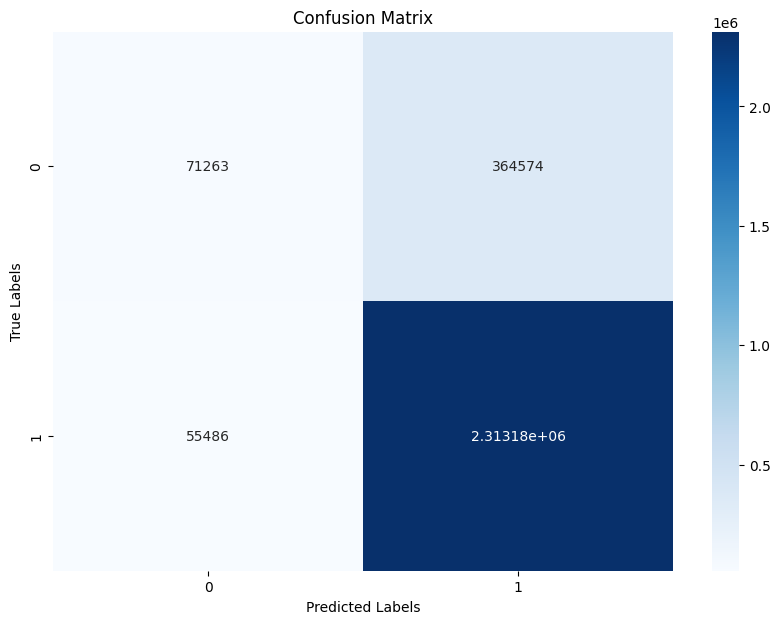

In [41]:
confusion_matrix = metrics.confusionMatrix().toArray()

print(confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  # 'g' formats numbers as integers
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
